# Make Figures for first section of Results

"3.1 Deeper wintertime mixing in the southeast"

 - Figure 1
 - Supplementary Figures 1-3

Begin a session in Expanse with: galyleo launch --account ciw112 --partition large-shared --cpus 64 --memory 500 --time-limit 12:00:00 --conda-env df-parallel --conda-yml "${HOME}/df-parallel/samw_analysis_env.yml" --mamba

## imports

In [1]:

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask as da
from dask.diagnostics import ProgressBar

# plotting packages
#import seaborn as sb
#sb.set(style='ticks')
import h5py
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# regridding
import xesmf as xe

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("dask version =", da.__version__)
#print("seaborn version =", sb.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("xesmf version =", xe.__version__)


import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)


wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)


python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.3
xarray version = 2024.3.0
dask version = 2023.3.0
matplotlib version = 3.7.1
cmocean version = v3.0.3
cartopy version = 0.24.0
xesmf version = 0.8.7


## load model output

In [2]:

mod = xr.open_dataset('JRA55_pic_1m_mld_1958-2022.nc')

# correct the coordinates and fix names
month = np.arange(1,13,1)
year = np.arange(1958.5,2022.51,1)
mod = mod.assign_coords(record=year)
mod = mod.assign_coords(time_counter=month)
mod = mod.rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month'})

# retrieve information
lon = mod.coords['lon']
lat = mod.coords['lat']

mod

<xarray.Dataset> Size: 93MB
Dimensions:               (year: 65, y: 149, x: 182, nvertex: 4, month: 12,
                           axis_nbounds: 2)
Coordinates:
    lat                   (y, x) float32 108kB ...
    lon                   (y, x) float32 108kB ...
    time_centered         (month) object 96B ...
  * year                  (year) float64 520B 1.958e+03 1.96e+03 ... 2.022e+03
  * month                 (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area                  (year, y, x) float32 7MB ...
    bounds_nav_lat        (y, x, nvertex) float32 434kB ...
    bounds_nav_lon        (y, x, nvertex) float32 434kB ...
    mldr10_1              (year, month, y, x) float32 85MB ...
    time_centered_bounds  (month, axis_nbounds) object 192B ...
    time_counter_bounds   (month, axis_nbounds) object 192B ...
Attributes: (12/13)
    Conventions:               CF-1.6
    name:                      ORCA2_1m_19580101_19581231_grid_T
    description:               ocean T grid variables
    title:                     ocean T grid variables
    timeStamp:                 2023-Apr-08 19:11:22 GMT
    uuid:                      acba51b8-706c-471b-b74c-ae94d0879f9c
    ...                        ...
    ni:                        182
    jbegin:                    0
    nj:                        2
    history:                   Thu Sep 14 18:25:22 2023: ncks -v mldr10_1 JRA...
    NCO:                       netCDF Operators version 4.9.3 (Homepage = htt...
    nco_openmp_thread_number:  1

## regrid the data


In [3]:
mld = mod['mldr10_1']
area = mod['area']

ds_out = xe.util.grid_global(0.5,0.5)
ds_out

regridder = xe.Regridder(mld, ds_out, 'bilinear', ignore_degenerate=True)
mld_reg = regridder(mld)


## monthly anomaly (on both native and regular grid)

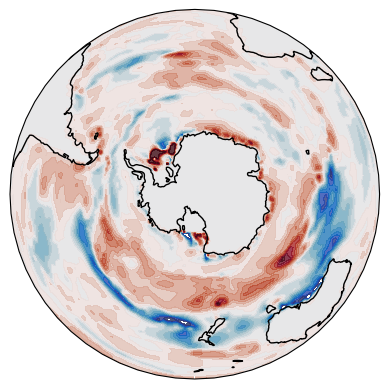

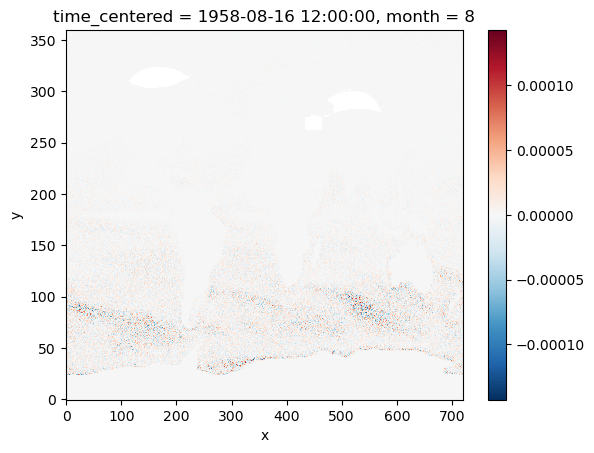

In [4]:
mld_anom = mld - mld.mean(dim='year')
mld_reg_anom = mld_reg - mld_reg.mean(dim='year')

proj = ccrs.Orthographic(central_latitude=-90)
levs = np.arange(-100,101,10)
colmap = lighten(cmo.balance, alpha=0.8)

plt.figure()
ax1 = plt.subplot(projection=proj)
ax1.contourf(mld_reg_anom.coords['lon'], mld_reg_anom.coords['lat'], mld_reg_anom.isel(year=1, month=8), \
             transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='max')
ax1.add_feature(cfeature.COASTLINE)

### make sure that the monthly anomaly has been calculated properly... there should be all zeros in next figure
plt.figure()
mld_reg_anom.sel(month=8).mean(dim='year').plot()


## prepare the MLD dataset for EOFs

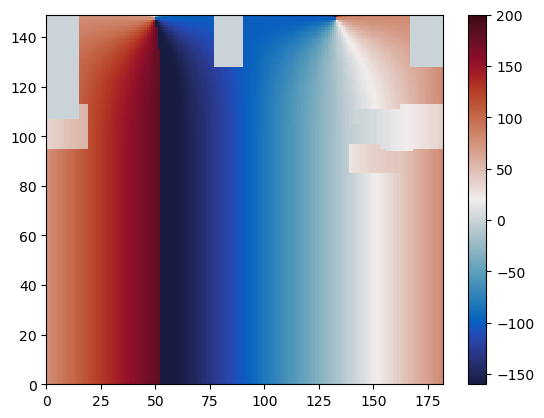

In [5]:
plt.figure()
plt.pcolormesh(mld_anom.coords['lon'], cmap=cmo.balance, vmin=-160, vmax=200)
plt.colorbar()

In [6]:
mld_anom = mld_anom.roll(x=30, roll_coords=True)
mld_anom

<xarray.DataArray 'mldr10_1' (year: 65, month: 12, y: 149, x: 182)> Size: 85MB
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-1.24097443e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -3.55755615e+00, -1.14660473e+01, -8.87749863e+00],
         [-4.56066132e-01,  0.00000000e+00,  0.00000000e+00, ...,
          -1.80569649e+01, -1.59394169e+01, -3.34006310e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.84422016e+01, -4.03928375e+00, -4.46891785e-01]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
           4.27605057e+00,  5.77113342e+00,  8.69789124e-01],
         [ 5.08052826e-01,  0.00000000e+00,  0.00000000e+00, ...,
           1.11885452e+01,  2.74109650e+00,  8.54854584e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           5.05814743e+00,  1.07796860e+00,  5.02662659e-01]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 5.54122925e-01,  0.00000000e+00,  0.00000000e+00, ...,
           1.49722290e+00,  7.46928406e+00,  1.92161179e+00],
         [ 4.96360779e-01,  0.00000000e+00,  0.00000000e+00, ...,
           1.04940224e+01,  3.29885483e+00,  9.45770264e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           4.37240601e+00,  1.04801559e+00,  4.94785309e-01]]]],
      dtype=float32)
Coordinates:
    lat            (y, x) float32 108kB -78.19 -78.19 -78.19 ... 75.1 74.23
    lon            (y, x) float32 108kB 22.0 24.0 26.0 ... 83.26 83.05 82.87
    time_centered  (month) object 96B 1958-01-16 12:00:00 ... 1958-12-16 12:0...
  * year           (year) float64 520B 1.958e+03 1.96e+03 ... 2.022e+03
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x

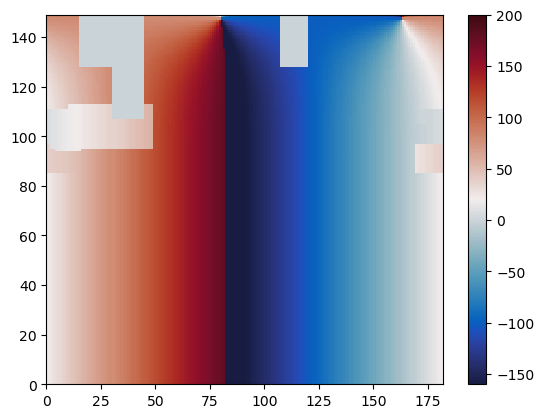

In [7]:
plt.figure()
plt.pcolormesh(mld_anom.coords['lon'], cmap=cmo.balance, vmin=-160, vmax=200)
plt.colorbar()

<xarray.DataArray 'lon' ()> Size: 4B
array(22.000566, dtype=float32)
Coordinates:
    lat      float32 4B -78.19
    lon      float32 4B 22.0


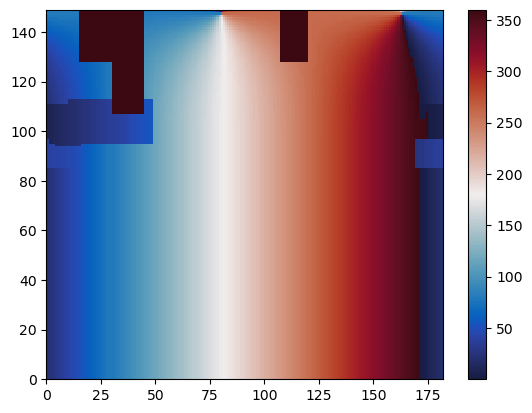

In [8]:
# fix the native grid so that all longitudes are positive
lon = mld_anom.coords['lon']
lat = mld_anom.coords['lat']
lon_positive = lon.where(lon >= 0.0, lon + 360.0)
print(lon_positive[0,0])

mld_anom = mld_anom.assign_coords({"lon":lon_positive})

plt.figure()
plt.pcolormesh(mld_anom.coords['lon'], cmap=cmo.balance)
plt.colorbar()

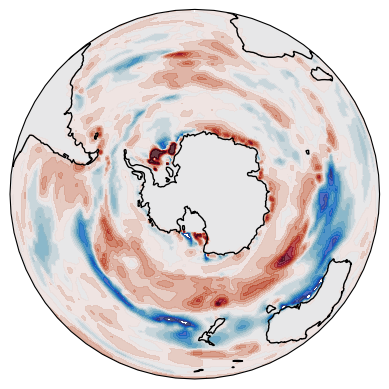

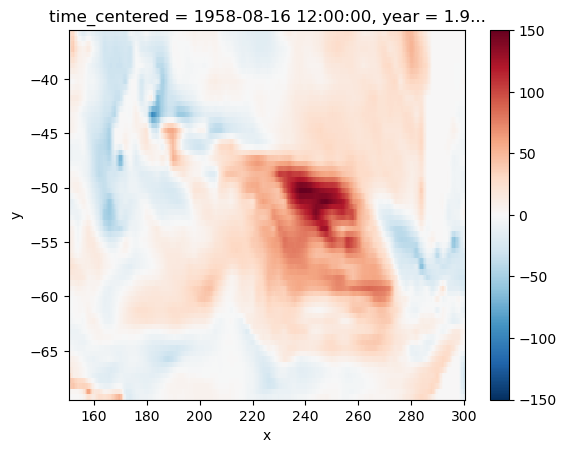

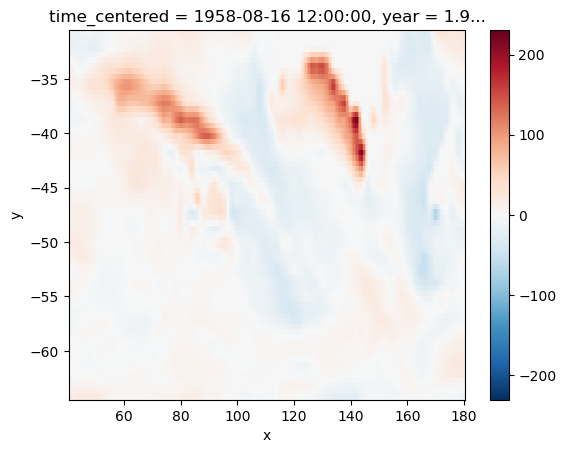

In [9]:
# add the regularly spaced coordinate values to the x and y dimensions for selection of boxes
lon_norm = ds_out.coords['lon'][0,:].values
lon_norm[lon_norm < 0] += 360
lat_norm = ds_out.coords['lat'][:,1].values
mld_reg_month_anomaly = mld_reg_anom.assign_coords({"x":lon_norm, "y":lat_norm})
mld_reg_month_anomaly = mld_reg_month_anomaly.sortby(mld_reg_month_anomaly.x)
mld_reg_month_anomaly = mld_reg_month_anomaly.drop_vars(['lon','lat'])

# view result
levs = np.arange(-100,101,10)
colmap = lighten(cmo.balance, alpha=0.8)
plt.figure()
ax1 = plt.subplot(projection=proj)
ax1.contourf(mld_reg_month_anomaly.coords['x'], mld_reg_month_anomaly.coords['y'], mld_reg_month_anomaly.isel(year=1, month=8), \
             transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='max')
ax1.add_feature(cfeature.COASTLINE)


### isolate the south Pacific between 170-320 E and 20-90 S
# for the regular MLD data
plon1 = 150.5; plon2 = 300.5
plat1 = -69.5; plat2 = -35.5
spac_mld_reg_anom = mld_reg_month_anomaly.sel(x=slice(plon1,plon2), y=slice(plat1,plat2))

# isolate the south Indian between 60-180 E and 20-90 S
ilon1 = 40.5; ilon2 = 180.5
ilat1 = -64.5; ilat2 = -30.5
sind_mld_reg_anom = mld_reg_month_anomaly.sel(x=slice(ilon1,ilon2), y=slice(ilat1,ilat2))

### check it worked
plt.figure()
spac_mld_reg_anom.sel(year=1970.5, month=8).plot()
plt.figure()
sind_mld_reg_anom.sel(year=1970.5, month=8).plot()


/scratch/pbuchanan/job_36469628/ipykernel_1995743/657300324.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(spac_mld_anom.coords['lon'], spac_mld_anom.coords['lat'], spac_mld_anom.sel(year=1970.5, month=8))
/scratch/pbuchanan/job_36469628/ipykernel_1995743/657300324.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(sind_mld_anom.coords['lon'], sind_mld_anom.coords['lat'], sind_mld_anom.sel(year=1970.5, month=8))
/scratch/pbuchanan/job_36469628/ipykernel_1995743/657300324.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as

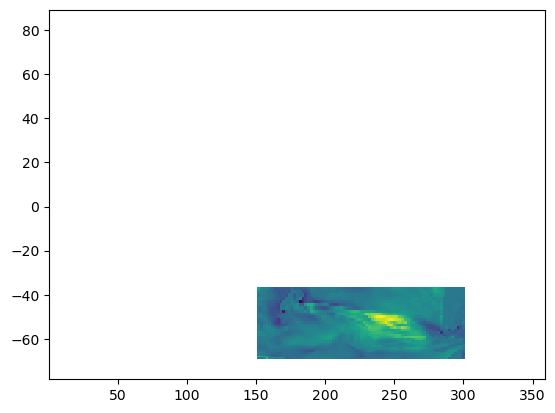

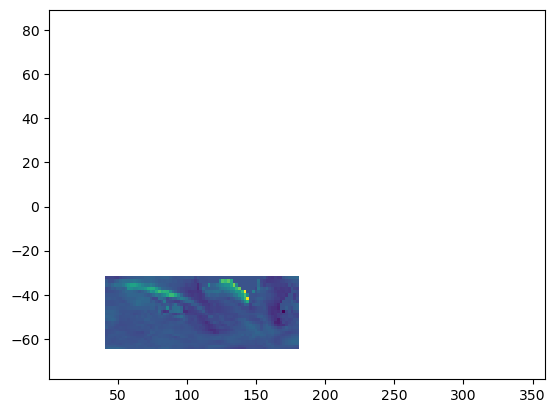

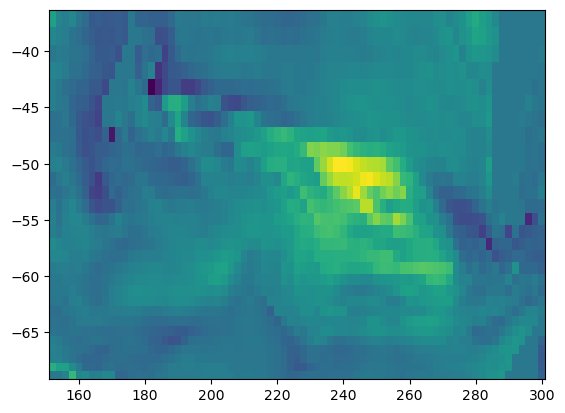

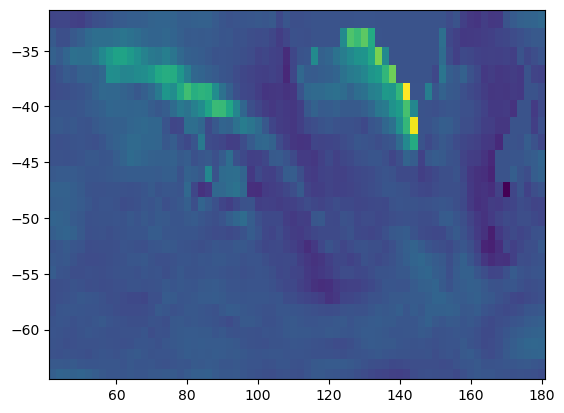

In [10]:
# for the native MLD data
spac_mld_anom = mld_anom.where((mld_anom.coords['lon'] > plon1) & (mld_anom.coords['lon'] < plon2), other=np.nan)
spac_mld_anom = spac_mld_anom.where((spac_mld_anom.coords['lat'] > plat1) & (spac_mld_anom.coords['lat'] < plat2), other=np.nan)
spac_area = area.where((mld_anom.coords['lon'] > plon1) & (mld_anom.coords['lon'] < plon2), other=np.nan)
spac_area = spac_area.where((spac_mld_anom.coords['lat'] > plat1) & (spac_mld_anom.coords['lat'] < plat2), other=np.nan)

sind_mld_anom = mld_anom.where((mld_anom.coords['lon'] > ilon1) & (mld_anom.coords['lon'] < ilon2), other=np.nan)
sind_mld_anom = sind_mld_anom.where((sind_mld_anom.coords['lat'] > ilat1) & (sind_mld_anom.coords['lat'] < ilat2), other=np.nan)
sind_area = area.where((mld_anom.coords['lon'] > ilon1) & (mld_anom.coords['lon'] < ilon2), other=np.nan)
sind_area = sind_area.where((sind_mld_anom.coords['lat'] > ilat1) & (sind_mld_anom.coords['lat'] < ilat2), other=np.nan)

plt.figure()
plt.pcolormesh(spac_mld_anom.coords['lon'], spac_mld_anom.coords['lat'], spac_mld_anom.sel(year=1970.5, month=8))
plt.figure()
plt.pcolormesh(sind_mld_anom.coords['lon'], sind_mld_anom.coords['lat'], sind_mld_anom.sel(year=1970.5, month=8))

spac_mld_anom = spac_mld_anom.where(~np.isnan(spac_mld_anom), drop=True)
sind_mld_anom = sind_mld_anom.where(~np.isnan(sind_mld_anom), drop=True)
spac_area = spac_area.where(~np.isnan(spac_area), drop=True)
sind_area = sind_area.where(~np.isnan(sind_area), drop=True)


plt.figure()
plt.pcolormesh(spac_mld_anom.coords['lon'], spac_mld_anom.coords['lat'], spac_mld_anom.sel(year=1970.5, month=8))
plt.figure()
plt.pcolormesh(sind_mld_anom.coords['lon'], sind_mld_anom.coords['lat'], sind_mld_anom.sel(year=1970.5, month=8))



## blend years and months into one time dimension

In [11]:
from datetime import datetime, timedelta

start_date = datetime(1958, 1, 1)
end_date = datetime(2022, 12, 31)
time = pd.date_range(start=start_date, end=end_date, freq="MS") + pd.DateOffset(days=14)
time

# blend years and months into one time dimension
spac_mld_anom = spac_mld_anom.stack(time=("year", "month"))
sind_mld_anom = sind_mld_anom.stack(time=("year", "month"))
spac_mld_anom = spac_mld_anom.drop_vars(['year', 'month', 'time_centered'])
sind_mld_anom = sind_mld_anom.drop_vars(['year', 'month', 'time_centered'])
spac_mld_anom = spac_mld_anom.assign_coords(time=time)
sind_mld_anom = sind_mld_anom.assign_coords(time=time)

spac_mld_reg_anom = spac_mld_reg_anom.stack(time=("year", "month"))
sind_mld_reg_anom = sind_mld_reg_anom.stack(time=("year", "month"))
spac_mld_reg_anom = spac_mld_reg_anom.drop_vars(['year', 'month', 'time_centered'])
sind_mld_reg_anom = sind_mld_reg_anom.drop_vars(['year', 'month', 'time_centered'])
spac_mld_reg_anom = spac_mld_reg_anom.assign_coords(time=time)
sind_mld_reg_anom = sind_mld_reg_anom.assign_coords(time=time)


## Hovmoller of MLD anomalies in the regions of interest

Text(0, 0.5, 'Mixed layer depth anomaly (m)')

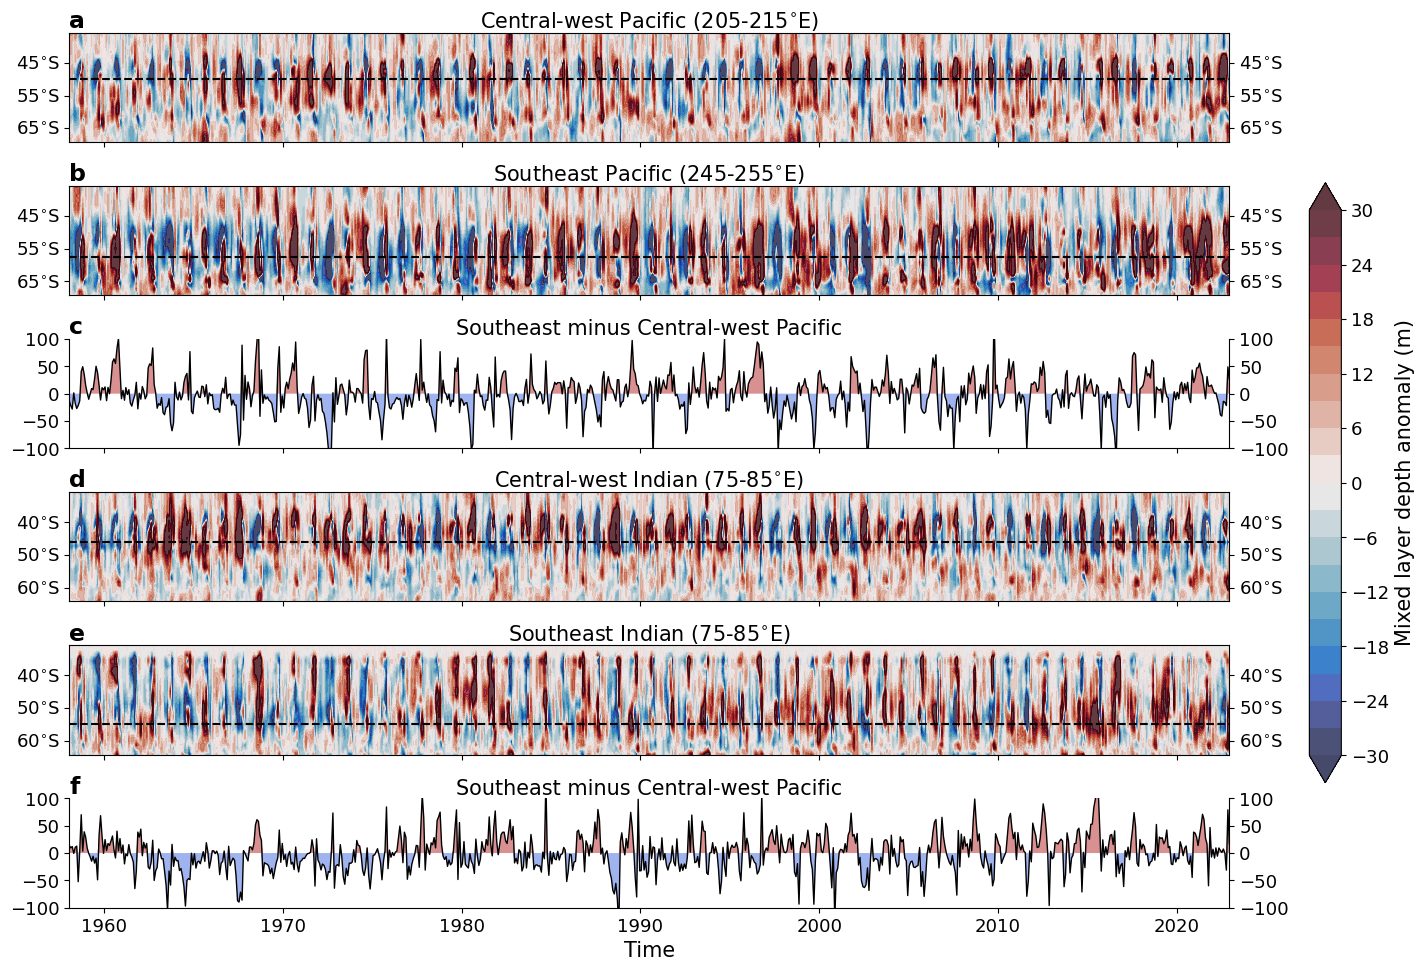

In [12]:
### chose longitudes
xpac_SE = 250.0
xpac_SW = 210.0
xind_SE = 120.0
xind_SW = 80.0
### chose latitudes
ypac_SE = -57.5
ypac_SW = -50.0
yind_SE = -55.0
yind_SW = -46.0
# set the window over which the longitudes and latitudes will be averaged for plotting
dlon = 10.0
dlat = 5.0


### calculate the hovmollers
hov_pac_SE = spac_mld_reg_anom.sel(x=slice(xpac_SE-dlon*0.5,xpac_SE+dlon*0.5)).mean(dim="x")
hov_pac_SW = spac_mld_reg_anom.sel(x=slice(xpac_SW-dlon*0.5,xpac_SW+dlon*0.5)).mean(dim="x")
hov_ind_SE = sind_mld_reg_anom.sel(x=slice(xind_SE-dlon*0.5,xind_SE+dlon*0.5)).mean(dim="x")
hov_ind_SW = sind_mld_reg_anom.sel(x=slice(xind_SW-dlon*0.5,xind_SW+dlon*0.5)).mean(dim="x")

### calculate the timeseries
ts_pac_SE = hov_pac_SE.sel(y=slice(ypac_SE-dlat*0.5,ypac_SE+dlat*0.5)).mean(dim=["y"])
ts_pac_SW = hov_pac_SW.sel(y=slice(ypac_SW-dlat*0.5,ypac_SW+dlat*0.5)).mean(dim=["y"])
ts_ind_SE = hov_ind_SE.sel(y=slice(yind_SE-dlat*0.5,yind_SE+dlat*0.5)).mean(dim=["y"])
ts_ind_SW = hov_ind_SW.sel(y=slice(yind_SW-dlat*0.5,yind_SW+dlat*0.5)).mean(dim=["y"])

levs = np.arange(-30,31,3)
colmap = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
wid = 1.0
cols = ['firebrick', 'royalblue', 'k']
lwid = [0.5, 0.5, 1.0]

fig = plt.figure(figsize=(16,10), facecolor='w')
gs = GridSpec(6,1)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax6 = plt.subplot(gs[5])

ax3.spines['top'].set_visible(False)
ax6.spines['top'].set_visible(False)

ax1.tick_params(labelsize=fstic, labelbottom=False, labelright=True, right=True)
ax2.tick_params(labelsize=fstic, labelbottom=False, labelright=True, right=True)
ax3.tick_params(labelsize=fstic, labelbottom=False, labelright=True, right=True)
ax4.tick_params(labelsize=fstic, labelbottom=False, labelright=True, right=True)
ax5.tick_params(labelsize=fstic, labelbottom=False, labelright=True, right=True)
ax6.tick_params(labelsize=fstic, labelright=True, right=True)

p1 = ax1.contourf(time, spac_mld_reg_anom.coords['y'], hov_pac_SW, cmap=colmap, levels=levs, extend='both')
ax2.contourf(time, spac_mld_reg_anom.coords['y'], hov_pac_SE, cmap=colmap, levels=levs, extend='both')

ax1.plot(time, np.ones(len(time))*ypac_SW, 'k--')
ax2.plot(time, np.ones(len(time))*ypac_SE, 'k--')
#ax3.plot(time, ts_pac_SE, color=cols[0], linewidth=lwid[0], alpha=0.25)
#ax3.plot(time, ts_pac_SW, color=cols[1], linewidth=lwid[1], alpha=0.25)
ax3.plot(time, ts_pac_SE - ts_pac_SW, color=cols[2], linewidth=lwid[2])

ax3.fill_between(time, (ts_pac_SE - ts_pac_SW).where((ts_pac_SE - ts_pac_SW) > 0.0, other=0.0), alpha=0.5, facecolor=cols[0])
ax3.fill_between(time, (ts_pac_SE - ts_pac_SW).where((ts_pac_SE - ts_pac_SW) < 0.0, other=0.0), alpha=0.5, facecolor=cols[1])

ax4.contourf(time, sind_mld_reg_anom.coords['y'], hov_ind_SW, cmap=colmap, levels=levs, extend='both')
ax5.contourf(time, sind_mld_reg_anom.coords['y'], hov_ind_SE, cmap=colmap, levels=levs, extend='both')

ax4.plot(time, np.ones(len(time))*yind_SW, 'k--')
ax5.plot(time, np.ones(len(time))*yind_SE, 'k--')
#ax6.plot(time, ts_ind_SE, color=cols[0], linewidth=lwid[0], alpha=0.25)
#ax6.plot(time, ts_ind_SW, color=cols[1], linewidth=lwid[1], alpha=0.25)
ax6.plot(time, ts_ind_SE - ts_ind_SW, color=cols[2], linewidth=lwid[2])

ax6.fill_between(time, (ts_ind_SE - ts_ind_SW).where((ts_ind_SE - ts_ind_SW) > 0.0, other=0.0), alpha=0.5, facecolor=cols[0])
ax6.fill_between(time, (ts_ind_SE - ts_ind_SW).where((ts_ind_SE - ts_ind_SW) < 0.0, other=0.0), alpha=0.5, facecolor=cols[1])

ax3.set_yticks(np.arange(-100,101,50))
ax3.set_ylim(-100,100)
ax6.set_yticks(np.arange(-100,101,50))
ax6.set_ylim(-100,100)

ax1.set_yticks(np.arange(-65,-39,10), ['65$^{\circ}$S', '55$^{\circ}$S', '45$^{\circ}$S'])
ax2.set_yticks(np.arange(-65,-39,10), ['65$^{\circ}$S', '55$^{\circ}$S', '45$^{\circ}$S'])
ax4.set_yticks(np.arange(-60,-34,10), ['60$^{\circ}$S', '50$^{\circ}$S', '40$^{\circ}$S'])
ax5.set_yticks(np.arange(-60,-34,10), ['60$^{\circ}$S', '50$^{\circ}$S', '40$^{\circ}$S'])

ax3.set_xlim(time[0], time[-1])
ax6.set_xlim(time[0], time[-1])
ax6.set_xlabel("Time", fontsize=fslab)

plt.subplots_adjust(right=0.85, bottom=0.075, top=0.95, hspace=0.40)

xx = 0.0; yy = 1.00
plt.text(xx,yy,'a', fontsize=fslab+2, fontweight='bold', ha='left', va='bottom', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, fontweight='bold', ha='left', va='bottom', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontsize=fslab+2, fontweight='bold', ha='left', va='bottom', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontsize=fslab+2, fontweight='bold', ha='left', va='bottom', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontsize=fslab+2, fontweight='bold', ha='left', va='bottom', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontsize=fslab+2, fontweight='bold', ha='left', va='bottom', transform=ax6.transAxes)

xx = 0.5; yy = 1.00
plt.text(xx,yy,'Central-west Pacific (%i-%i$^{\circ}$E)'%(xpac_SW-dlon*0.5, xpac_SW+dlon*0.5), fontsize=fslab, ha='center', va='bottom', transform=ax1.transAxes)
plt.text(xx,yy,'Southeast Pacific (%i-%i$^{\circ}$E)'%(xpac_SE-dlon*0.5, xpac_SE+dlon*0.5), fontsize=fslab, ha='center', va='bottom', transform=ax2.transAxes)
plt.text(xx,yy,'Southeast minus Central-west Pacific', fontsize=fslab, ha='center', va='bottom', transform=ax3.transAxes)
plt.text(xx,yy,'Central-west Indian (%i-%i$^{\circ}$E)'%(xind_SW-dlon*0.5, xind_SW+dlon*0.5), fontsize=fslab, ha='center', va='bottom', transform=ax4.transAxes)
plt.text(xx,yy,'Southeast Indian (%i-%i$^{\circ}$E)'%(xind_SW-dlon*0.5, xind_SW+dlon*0.5), fontsize=fslab, ha='center', va='bottom', transform=ax5.transAxes)
plt.text(xx,yy,'Southeast minus Central-west Pacific', fontsize=fslab, ha='center', va='bottom', transform=ax6.transAxes)



cbax = fig.add_axes([0.9,0.2,0.02,0.6])
cbar = plt.colorbar(p1, cax=cbax, orientation='vertical', ticks=levs[::2])
cbar.ax.tick_params(labelsize=fstic)
cbar.ax.set_ylabel('Mixed layer depth anomaly (m)', fontsize=fslab)



In [13]:
os.getcwd()

fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_hovmoller.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_hovmoller.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_hovmoller_trans.png', dpi=300, bbox_inches='tight', transparent=True)


## perform the EOF analysis

In [14]:
### Single Value Decomposition on Pacific data

weights = spac_area.mean(dim='year') / spac_area.mean(dim='year').sum()
W_pac = weights**0.5
X = spac_mld_anom * W_pac
Xpac = X.stack(space=("y","x"))

U, S, V = np.linalg.svd(Xpac.T.values, full_matrices=False)

### reconstruct the dimensions of the original data

U_ = Xpac.T * 0 + U
U_pac = U_.unstack('space') * W_pac**(-1)
U_pac = U_pac.rename({"time":"mode"})
U_pac = U_pac.assign_coords({"mode":np.arange(len(S))})

S_pac = xr.DataArray(
    S,
    dims=["mode"],
    coords={"mode":np.arange(len(S))}
)

V_pac = xr.DataArray(
    V.T,
    dims=["time","mode"],
    coords={
        "time":Xpac.coords['time'].values,
        "mode":np.arange(len(S))
    }
)

# variance explained
S2_pac = S_pac**2.0
VE_pac = S2_pac / S2_pac.sum()

print(np.shape(Xpac.T))
print(np.shape(U_pac))
print(np.shape(S_pac))
print(np.shape(V_pac))
print(np.shape(VE_pac))


(2175, 780)
(780, 29, 75)
(780,)
(780, 780)
(780,)


In [15]:
### Single Value Decomposition on Indian data

weights = sind_area.mean(dim='year') / sind_area.mean(dim='year').sum()
W_ind = weights**0.5
X = sind_mld_anom * W_ind
Xind = X.stack(space=("y","x"))

U, S, V = np.linalg.svd(Xind.T.values, full_matrices=False)

### reconstruct the dimensions of the original data

U_ = Xind.T * 0 + U
U_ind = U_.unstack('space') * W_ind**(-1)
U_ind = U_ind.rename({"time":"mode"})
U_ind = U_ind.assign_coords({"mode":np.arange(len(S))})

S_ind = xr.DataArray(
    S,
    dims=["mode"],
    coords={"mode":np.arange(len(S))}
)

V_ind = xr.DataArray(
    V.T,
    dims=["time","mode"],
    coords={
        "time":Xind.coords['time'].values,
        "mode":np.arange(len(S))
    }
)

# variance explained
S2_ind = S_ind**2.0
VE_ind = S2_ind / S2_ind.sum()

print(np.shape(Xind.T))
print(np.shape(U_ind))
print(np.shape(S_ind))
print(np.shape(V_ind))
print(np.shape(VE_ind))


(1872, 780)
(780, 26, 72)
(780,)
(780, 780)
(780,)


### Plot the variance explained

Total variance explained in Indian by first 2 modes = 0.35253716
Total variance explained in Pacific by first 2 modes = 0.41079193


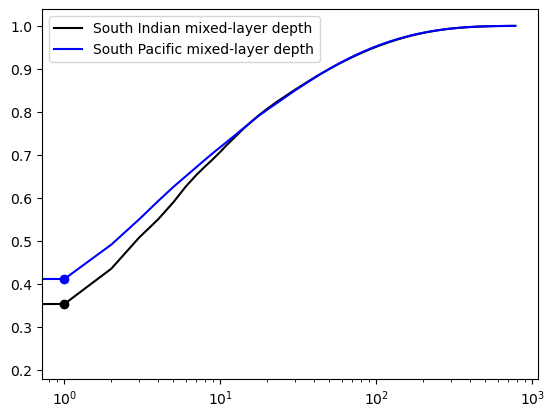

In [16]:
imodes = 1
print("Total variance explained in Indian by first %i modes ="%(imodes+1), VE_ind.cumsum().sel(mode=imodes).values)
print("Total variance explained in Pacific by first %i modes ="%(imodes+1), VE_pac.cumsum().sel(mode=imodes).values)

plt.figure()
plt.plot(np.arange(len(VE_ind)), VE_ind.cumsum(), color='k', label="South Indian mixed-layer depth")
plt.plot(np.arange(len(VE_pac)), VE_pac.cumsum(), color='b', label="South Pacific mixed-layer depth")
plt.scatter(imodes, VE_ind.cumsum().sel(mode=imodes), marker='o', color='k')
plt.scatter(imodes, VE_pac.cumsum().sel(mode=imodes), marker='o', color='b')
plt.legend()
plt.xscale('log')

## Make Figure 1

In [18]:
### regrid the EOFs to a regular grid

target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(plat1,plat2+0.5,0.5)),
        "lon": (["lon"], np.arange(plon1,plon2+0.5,0.5)),
    }
)

regridder = xe.Regridder(U_pac, target_grid, 'bilinear', ignore_degenerate=True, periodic=True)
U_pac_reg = regridder(U_pac)

target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(ilat1,ilat2+0.5,0.5)),
        "lon": (["lon"], np.arange(ilon1,ilon2+0.5,0.5)),
    }
)

regridder = xe.Regridder(U_ind, target_grid, 'bilinear', ignore_degenerate=True, periodic=True)
U_ind_reg = regridder(U_ind)



Text(0.05, 1.05, 'j')

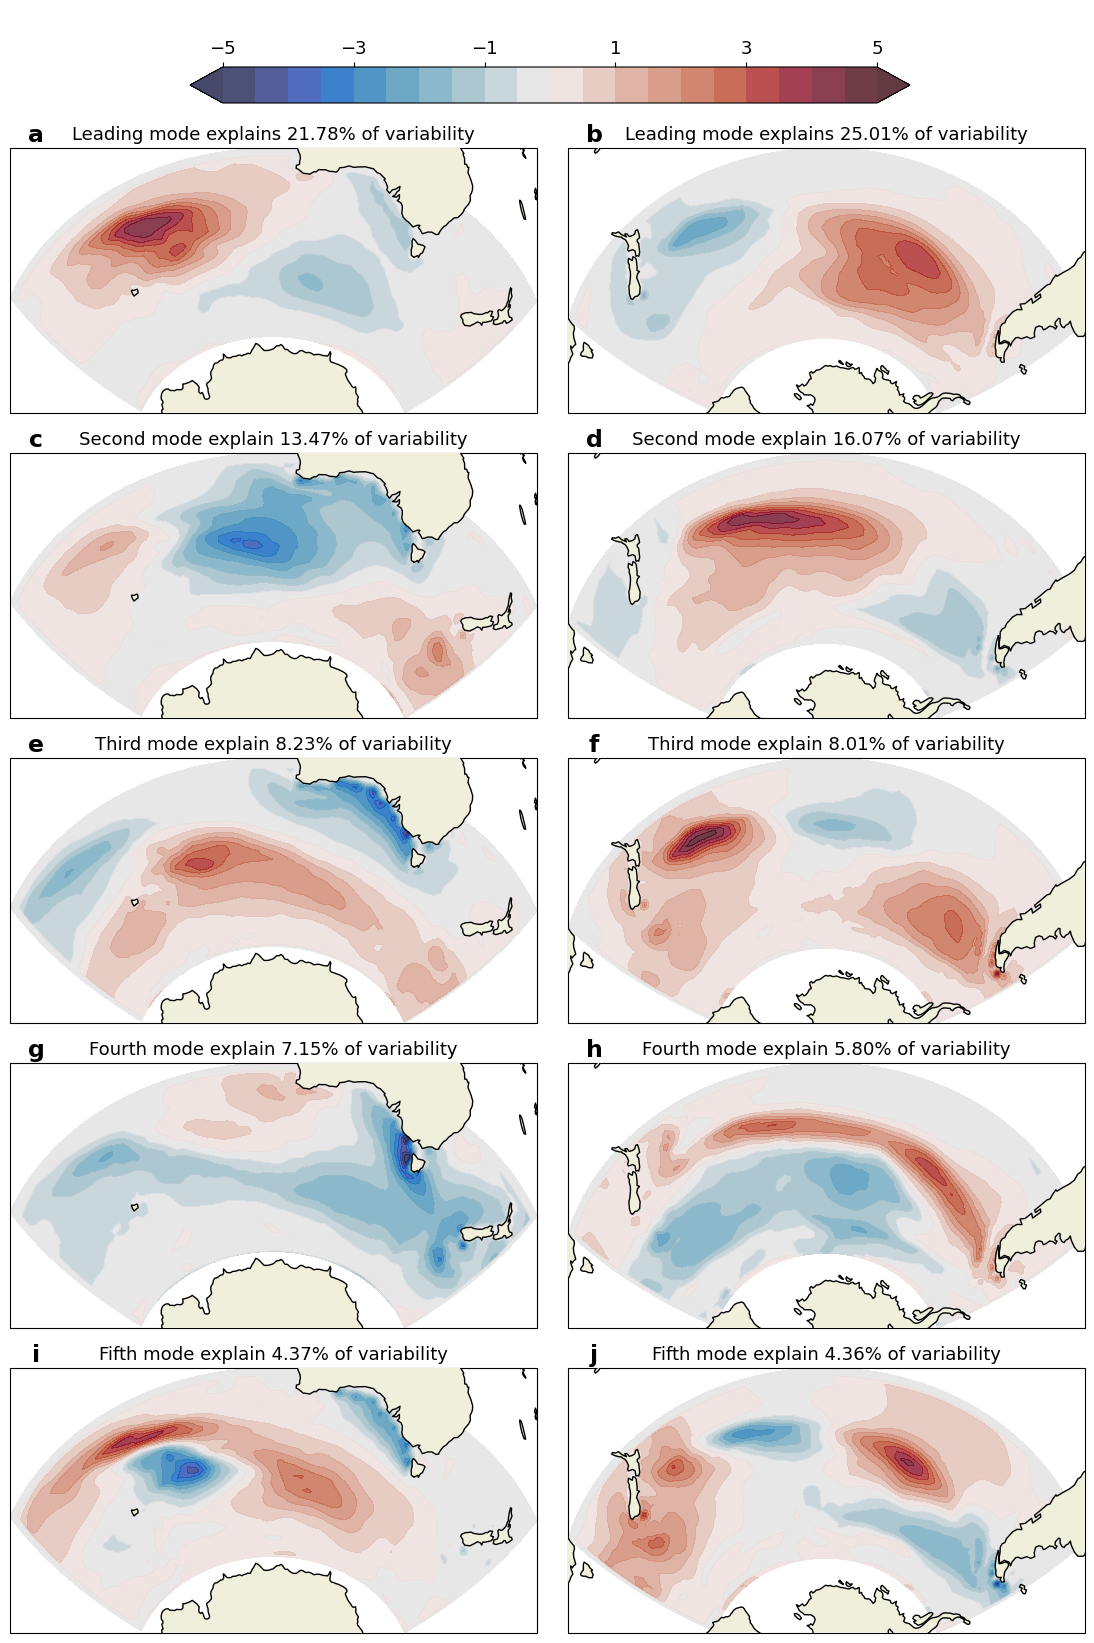

In [19]:
#%% Look at what the leading modes are in terms of spatial patterns

sind_proj = ccrs.Orthographic(central_latitude=-55, central_longitude=110)
spac_proj = ccrs.Orthographic(central_latitude=-60, central_longitude=225)

paclons = U_pac_reg.coords['lon']
paclats = U_pac_reg.coords['lat']
indlons = U_ind_reg.coords['lon']
indlats = U_ind_reg.coords['lat']


levs = np.arange(-5,5.1,0.5)
colmap = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
wid = 1.0

fig = plt.figure(figsize=(12,18), facecolor='w')
gs = GridSpec(5,2)

ax1 = plt.subplot(gs[0,0], projection=sind_proj)
ax2 = plt.subplot(gs[0,1], projection=spac_proj)
ax3 = plt.subplot(gs[1,0], projection=sind_proj)
ax4 = plt.subplot(gs[1,1], projection=spac_proj)
ax5 = plt.subplot(gs[2,0], projection=sind_proj)
ax6 = plt.subplot(gs[2,1], projection=spac_proj)
ax7 = plt.subplot(gs[3,0], projection=sind_proj)
ax8 = plt.subplot(gs[3,1], projection=spac_proj)
ax9 = plt.subplot(gs[4,0], projection=sind_proj)
ax10 = plt.subplot(gs[4,1], projection=spac_proj)

ax1.add_feature(cfeature.LAND, zorder=3)
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3)
ax2.add_feature(cfeature.COASTLINE, zorder=3)
ax3.add_feature(cfeature.LAND, zorder=3)
ax3.add_feature(cfeature.COASTLINE, zorder=3)
ax4.add_feature(cfeature.LAND, zorder=3)
ax4.add_feature(cfeature.COASTLINE, zorder=3)
ax5.add_feature(cfeature.LAND, zorder=3)
ax5.add_feature(cfeature.COASTLINE, zorder=3)
ax6.add_feature(cfeature.LAND, zorder=3)
ax6.add_feature(cfeature.COASTLINE, zorder=3)
ax7.add_feature(cfeature.LAND, zorder=3)
ax7.add_feature(cfeature.COASTLINE, zorder=3)
ax8.add_feature(cfeature.LAND, zorder=3)
ax8.add_feature(cfeature.COASTLINE, zorder=3)
ax9.add_feature(cfeature.LAND, zorder=3)
ax9.add_feature(cfeature.COASTLINE, zorder=3)
ax10.add_feature(cfeature.LAND, zorder=3)
ax10.add_feature(cfeature.COASTLINE, zorder=3)


p1 = ax1.contourf(indlons,indlats, U_ind_reg.sel(mode=0), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p2 = ax2.contourf(paclons,paclats, U_pac_reg.sel(mode=0), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Leading mode explains %.2f%% of variability'%(VE_ind.sel(mode=0).values*100), transform=ax1.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading mode explains %.2f%% of variability'%(VE_pac.sel(mode=0).values*100), transform=ax2.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 1 
p3 = ax3.contourf(indlons,indlats, U_ind_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p4 = ax4.contourf(paclons,paclats, U_pac_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Second mode explain %.2f%% of variability'%(VE_ind.sel(mode=imodes).values*100), transform=ax3.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Second mode explain %.2f%% of variability'%(VE_pac.sel(mode=imodes).values*100), transform=ax4.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 2 
p5 = ax5.contourf(indlons,indlats, U_ind_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p6 = ax6.contourf(paclons,paclats, U_pac_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Third mode explain %.2f%% of variability'%(VE_ind.sel(mode=imodes).values*100), transform=ax5.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Third mode explain %.2f%% of variability'%(VE_pac.sel(mode=imodes).values*100), transform=ax6.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 3 
p7 = ax7.contourf(indlons,indlats, U_ind_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p8 = ax8.contourf(paclons,paclats, U_pac_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Fourth mode explain %.2f%% of variability'%(VE_ind.sel(mode=imodes).values*100), transform=ax7.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Fourth mode explain %.2f%% of variability'%(VE_pac.sel(mode=imodes).values*100), transform=ax8.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 4 
p9 = ax9.contourf(indlons,indlats, U_ind_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p10 = ax10.contourf(paclons,paclats, U_pac_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Fifth mode explain %.2f%% of variability'%(VE_ind.sel(mode=imodes).values*100), transform=ax9.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Fifth mode explain %.2f%% of variability'%(VE_pac.sel(mode=imodes).values*100), transform=ax10.transAxes, va='center', ha='center', fontsize=fstic)

cbax = fig.add_axes([0.2,0.9,0.6,0.02])
cbar1 = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::4])
cbar1.ax.tick_params(labelsize=fstic, labelbottom=False, bottom=False, labeltop=True, top=True)
cbar1.ax.set_xlabel(' ', fontsize=fslab, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')

plt.subplots_adjust(left=0.05, top=0.875, right=0.95, bottom=0.05, wspace=0.05, hspace=0.15)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes)



In [20]:

fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_EOFpatterns.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_EOFpatterns.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_EOFpatterns_trans.png', dpi=300, bbox_inches='tight', transparent=True)


In [21]:
### reconstruct X from the EOF modes 
X_pac_reconstructed = (U_pac_reg * S_pac * V_pac.T)
X_ind_reconstructed = (U_ind_reg * S_ind * V_ind.T)


### Create indexes (similar to Takahashi et al., 2010)

In [22]:

# Pacific is positive then negative given spatial pattern of EOFs
I_pac_pos = ((S_pac.sel(mode=0) * V_pac.sel(mode=0).T + S_pac.sel(mode=1) * V_pac.sel(mode=1).T) / 
            ((S_pac.sel(mode=0))**2 + (S_pac.sel(mode=1))**2)**0.5)
I_pac_neg = ((S_pac.sel(mode=0) * V_pac.sel(mode=0).T - S_pac.sel(mode=1) * V_pac.sel(mode=1).T) / 
            ((S_pac.sel(mode=0))**2 + (S_pac.sel(mode=1))**2)**0.5)
# Indian is both negative given spatial pattern of EOFs
I_ind_pos = ((S_ind.sel(mode=0) * V_ind.sel(mode=0).T * (-1) - S_ind.sel(mode=1) * V_ind.sel(mode=1).T) / 
            ((S_ind.sel(mode=0))**2 + (S_ind.sel(mode=1))**2)**0.5)
I_ind_neg = ((S_ind.sel(mode=0) * V_ind.sel(mode=0).T * (-1) + S_ind.sel(mode=1) * V_ind.sel(mode=1).T) / 
            ((S_ind.sel(mode=0))**2 + (S_ind.sel(mode=1))**2)**0.5)



Text(0.05, 1.05, 'j')

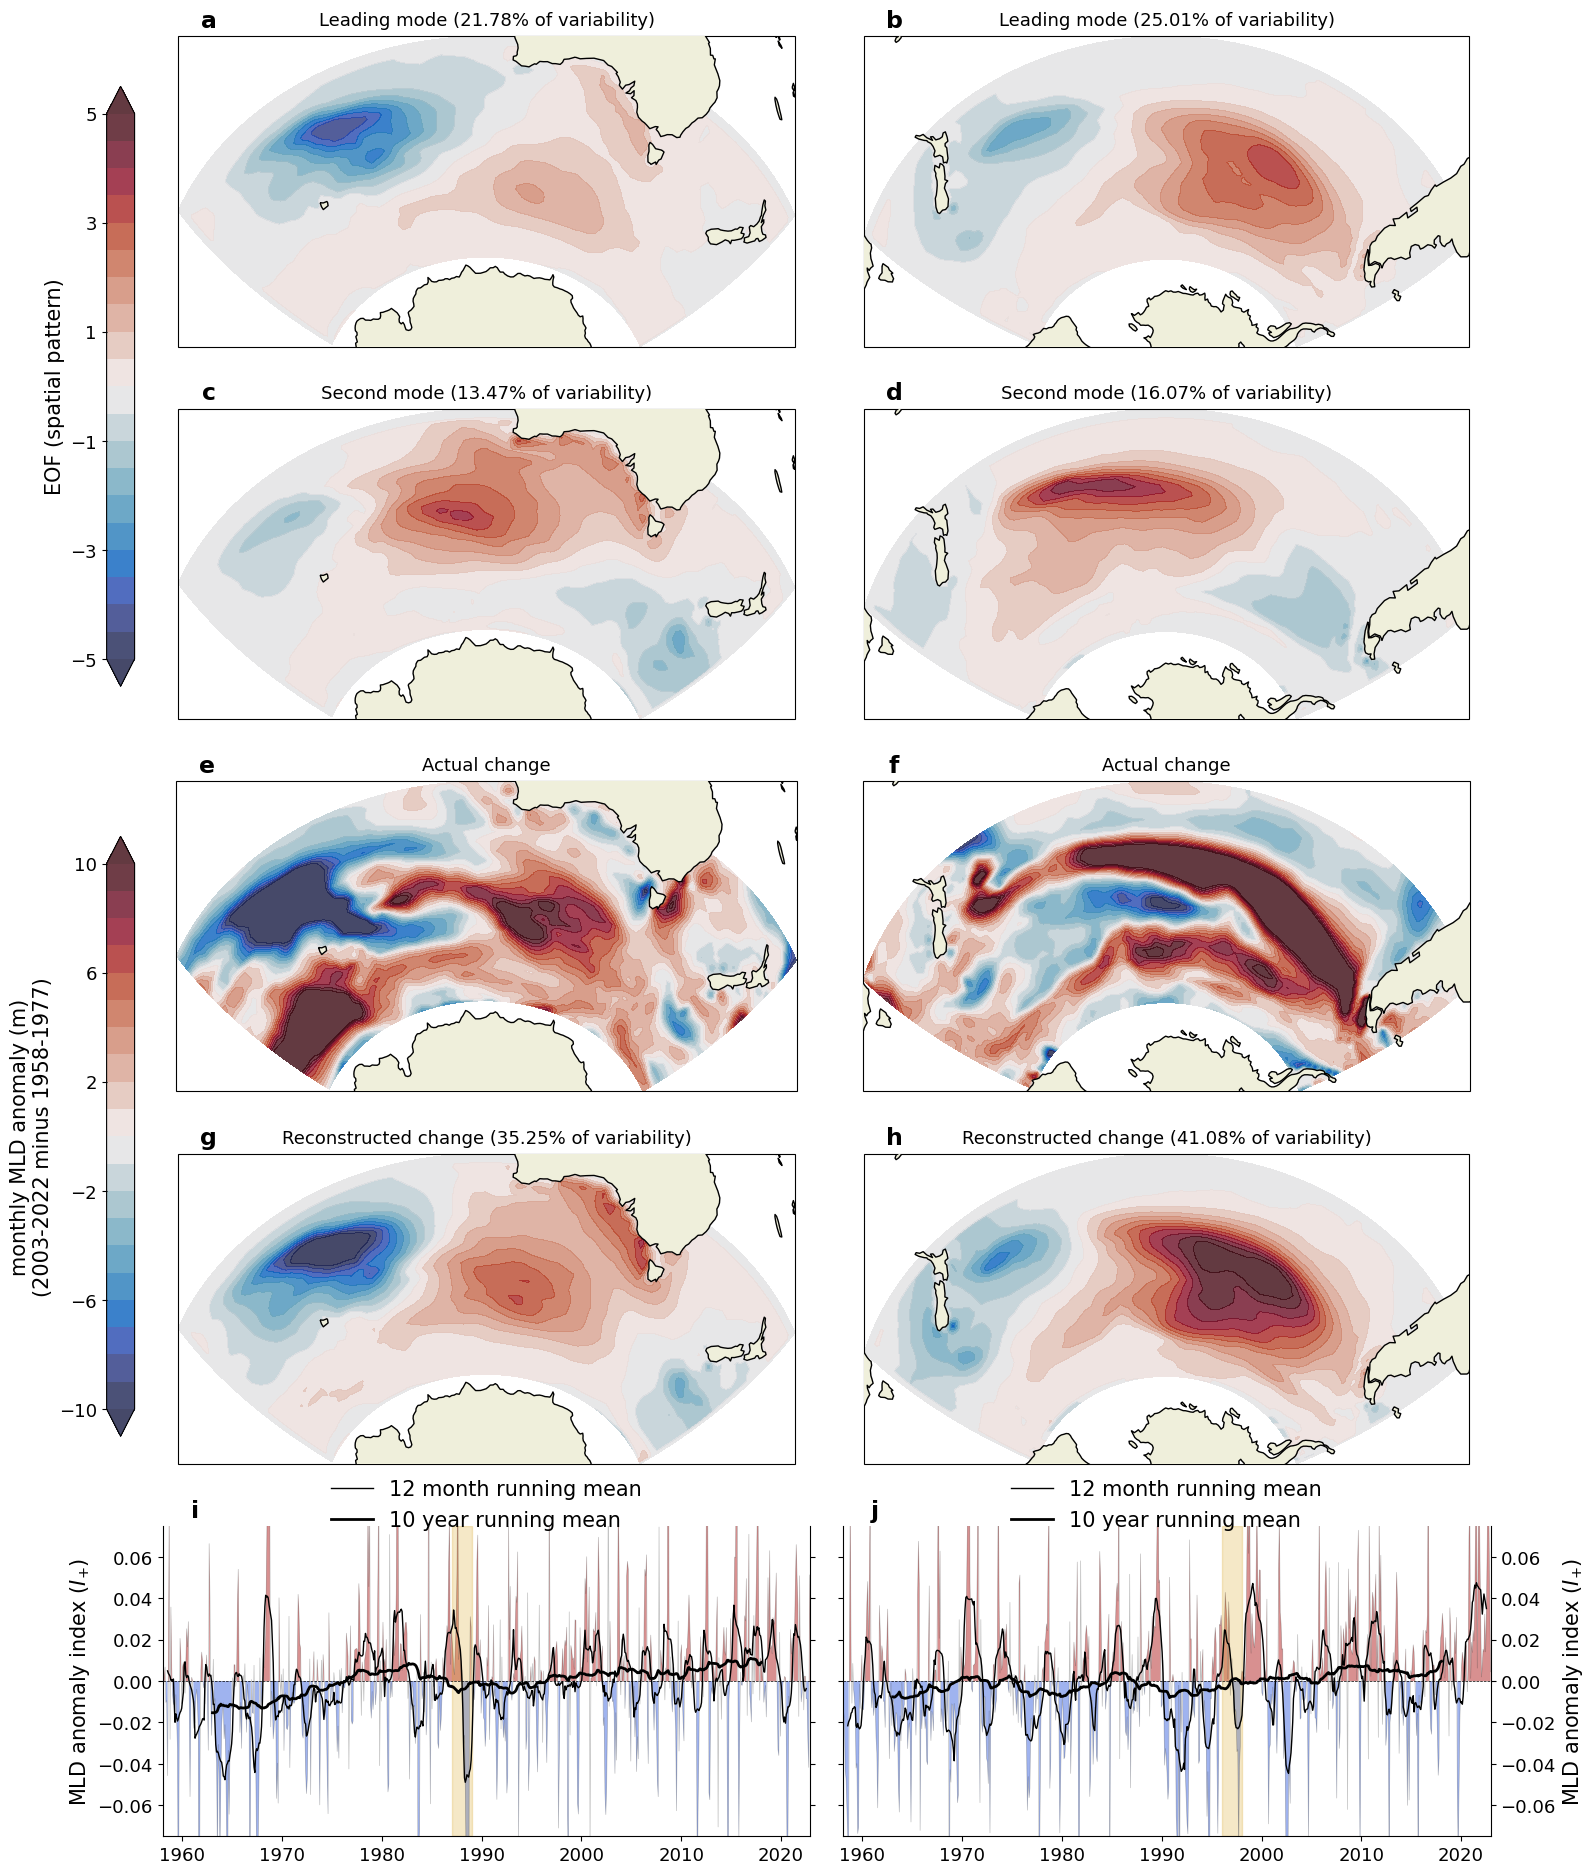

In [25]:
#%% Figure 1 

sind_proj = ccrs.Orthographic(central_latitude=-55, central_longitude=110)
spac_proj = ccrs.Orthographic(central_latitude=-60, central_longitude=225)

paclons = U_pac_reg.coords['lon']
paclats = U_pac_reg.coords['lat']
indlons = U_ind_reg.coords['lon']
indlats = U_ind_reg.coords['lat']

levs1 = np.arange(-5,5.1,0.5)
levs2 = np.arange(-10,11,1)
colmap = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
wid = 1.0

fig = plt.figure(figsize=(16,20), facecolor='w')
gs = GridSpec(5,2)

ax1 = plt.subplot(gs[0,0], projection=sind_proj)
ax2 = plt.subplot(gs[0,1], projection=spac_proj)
ax3 = plt.subplot(gs[1,0], projection=sind_proj)
ax4 = plt.subplot(gs[1,1], projection=spac_proj)
ax5 = plt.subplot(gs[2,0], projection=sind_proj)
ax6 = plt.subplot(gs[2,1], projection=spac_proj)
ax7 = plt.subplot(gs[3,0], projection=sind_proj)
ax8 = plt.subplot(gs[3,1], projection=spac_proj)
ax9 = plt.subplot(gs[4,0])
ax10 = plt.subplot(gs[4,1])

ax1.add_feature(cfeature.LAND, zorder=3)
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3)
ax2.add_feature(cfeature.COASTLINE, zorder=3)
ax3.add_feature(cfeature.LAND, zorder=3)
ax3.add_feature(cfeature.COASTLINE, zorder=3)
ax4.add_feature(cfeature.LAND, zorder=3)
ax4.add_feature(cfeature.COASTLINE, zorder=3)
ax5.add_feature(cfeature.LAND, zorder=3)
ax5.add_feature(cfeature.COASTLINE, zorder=3)
ax6.add_feature(cfeature.LAND, zorder=3)
ax6.add_feature(cfeature.COASTLINE, zorder=3)
ax7.add_feature(cfeature.LAND, zorder=3)
ax7.add_feature(cfeature.COASTLINE, zorder=3)
ax8.add_feature(cfeature.LAND, zorder=3)
ax8.add_feature(cfeature.COASTLINE, zorder=3)


ax9.tick_params(labelsize=fstic, right=True)
ax10.tick_params(labelsize=fstic, labelleft=False, right=True, labelright=True)
ax9.spines['top'].set_visible(False)
ax10.spines['top'].set_visible(False)

p1 = ax1.contourf(indlons,indlats, U_ind_reg.sel(mode=0)*-1, transform=ccrs.PlateCarree(), cmap=colmap, levels=levs1, extend='both')
p2 = ax2.contourf(paclons,paclats, U_pac_reg.sel(mode=0), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs1, extend='both')
plt.text(0.5,1.05,'Leading mode (%.2f%% of variability)'%(VE_ind.sel(mode=0).values*100), transform=ax1.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading mode (%.2f%% of variability)'%(VE_pac.sel(mode=0).values*100), transform=ax2.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 1 
p3 = ax3.contourf(indlons,indlats, U_ind_reg.sel(mode=imodes)*-1, transform=ccrs.PlateCarree(), cmap=colmap, levels=levs1, extend='both')
p4 = ax4.contourf(paclons,paclats, U_pac_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs1, extend='both')
plt.text(0.5,1.05,'Second mode (%.2f%% of variability)'%(VE_ind.sel(mode=imodes).values*100), transform=ax3.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Second mode (%.2f%% of variability)'%(VE_pac.sel(mode=imodes).values*100), transform=ax4.transAxes, va='center', ha='center', fontsize=fstic)

paclons = spac_mld_reg_anom.coords['x']
paclats = spac_mld_reg_anom.coords['y']
indlons = sind_mld_reg_anom.coords['x']
indlats = sind_mld_reg_anom.coords['y']

p5 = ax5.contourf(indlons,indlats, sind_mld_reg_anom.isel(time=slice(-240,-1)).mean(dim='time') - sind_mld_reg_anom.isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs2, extend='both')
p6 = ax6.contourf(paclons,paclats, spac_mld_reg_anom.isel(time=slice(-240,-1)).mean(dim='time') - spac_mld_reg_anom.isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs2, extend='both')

paclons = U_pac_reg.coords['lon']
paclats = U_pac_reg.coords['lat']
indlons = U_ind_reg.coords['lon']
indlats = U_ind_reg.coords['lat']

p7 = ax7.contourf(indlons,indlats, X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs2, extend='both')
p8 = ax8.contourf(paclons,paclats, X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs2, extend='both')


ax9.plot(I_ind_pos.coords['time'], I_ind_pos, color='k', linewidth=0.5, linestyle='-', alpha=0.25)
ax9.plot(I_ind_pos.coords['time'], I_ind_pos*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0)
ax9.plot(I_ind_pos.coords['time'], I_ind_pos.rolling(time=12, center=True).mean(), color='k', linewidth=1.0, linestyle='-', label="12 month running mean")
ax9.plot(I_ind_pos.coords['time'], I_ind_pos.rolling(time=120, center=True).mean(), color='k', linewidth=2.0, linestyle='-', label="10 year running mean")
ax10.plot(I_pac_pos.coords['time'], I_pac_pos, color='k', linewidth=0.5, linestyle='-', alpha=0.25)
ax10.plot(I_pac_pos.coords['time'], I_pac_pos*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0)
ax10.plot(I_pac_pos.coords['time'], I_pac_pos.rolling(time=12, center=True).mean(), color='k', linewidth=1.0, linestyle='-', label="12 month running mean")
ax10.plot(I_pac_pos.coords['time'], I_pac_pos.rolling(time=120, center=True).mean(), color='k', linewidth=2.0, linestyle='-', label="10 year running mean")

ax9.legend(loc='upper center', frameon=False, fontsize=fslab, bbox_to_anchor=(0.5,1.21))
ax10.legend(loc='upper center', frameon=False, fontsize=fslab, bbox_to_anchor=(0.5,1.21))

ax9.fill_between(I_ind_pos.coords['time'], I_ind_pos.where(I_ind_pos > 0.0, other=np.nan), alpha=0.5, facecolor='firebrick')
ax9.fill_between(I_ind_pos.coords['time'], I_ind_pos.where(I_ind_pos < 0.0, other=np.nan), alpha=0.5, facecolor='royalblue')
ax10.fill_between(I_pac_pos.coords['time'], I_pac_pos.where(I_pac_pos > 0.0, other=np.nan), alpha=0.5, facecolor='firebrick')
ax10.fill_between(I_pac_pos.coords['time'], I_pac_pos.where(I_pac_pos < 0.0, other=np.nan), alpha=0.5, facecolor='royalblue')

ax9.axvspan(I_ind_pos.coords['time'].sel(time="1987-01-01",method='nearest').values, \
            I_ind_pos.coords['time'].sel(time="1988-12-31",method='nearest').values, color='goldenrod', alpha=0.25)
ax10.axvspan(I_pac_pos.coords['time'].sel(time="1996-01-01",method='nearest').values, \
             I_pac_pos.coords['time'].sel(time="1997-12-31",method='nearest').values, color='goldenrod', alpha=0.25)

ax9.set_xlim(I_pac_pos.coords['time'].min(), I_pac_pos.coords['time'].max())
ax10.set_xlim(I_pac_pos.coords['time'].min(), I_pac_pos.coords['time'].max())
ax9.set_ylabel("MLD anomaly index ($I_{+}$)", fontsize=fslab)
ax10.set_ylabel("MLD anomaly index ($I_{+}$)", fontsize=fslab)
ax10.yaxis.set_label_position('right')

ax9.set_ylim(-0.075,0.075)
ax10.set_ylim(-0.075,0.075)

cbax1 = fig.add_axes([0.085,0.625,0.0175,0.30])
cbax5 = fig.add_axes([0.085,0.25,0.0175,0.30])

cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::4])
cbar1.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbar1.ax.set_ylabel('EOF (spatial pattern)', fontsize=fslab)
cbar1.ax.yaxis.set_label_position('left')

cbar5 = plt.colorbar(p5, cax=cbax5, orientation='vertical', ticks=levs2[::4])
cbar5.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbar5.ax.set_ylabel('monthly MLD anomaly (m)\n(2003-2022 minus 1958-1977)', fontsize=fslab)
cbar5.ax.yaxis.set_label_position('left')

plt.text(0.5,1.05,'Actual change', transform=ax5.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Actual change', transform=ax6.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Reconstructed change (%.2f%% of variability)'%(VE_ind.cumsum().sel(mode=imodes).values*100), transform=ax7.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Reconstructed change (%.2f%% of variability)'%(VE_pac.cumsum().sel(mode=imodes).values*100), transform=ax8.transAxes, va='center', ha='center', fontsize=fstic)

plt.subplots_adjust(left=0.12, top=0.95, right=0.95, bottom=0.05, wspace=0.05)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes)


In [26]:

fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_trend_reconstructed.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_trend_reconstructed.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_trend_reconstructed_trans.png', dpi=300, bbox_inches='tight', transparent=True)



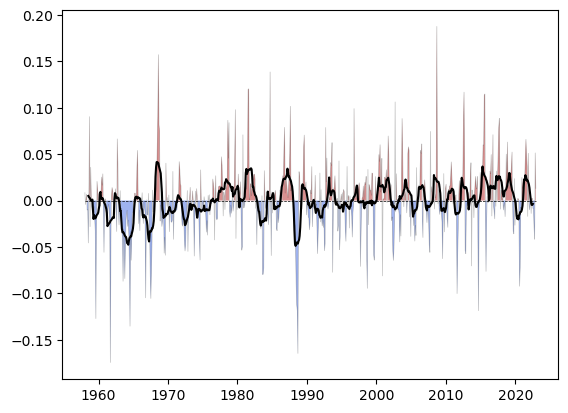

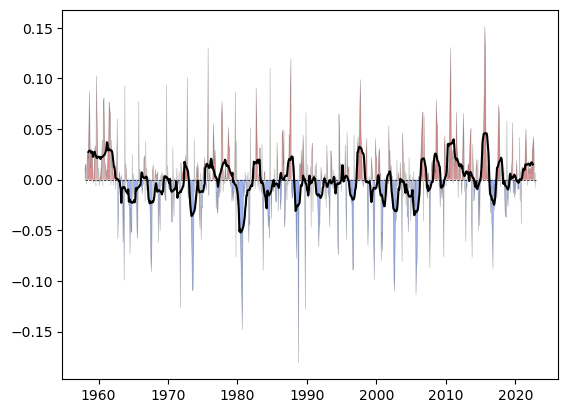

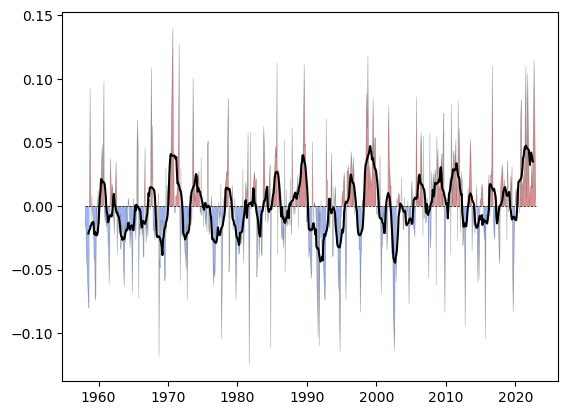

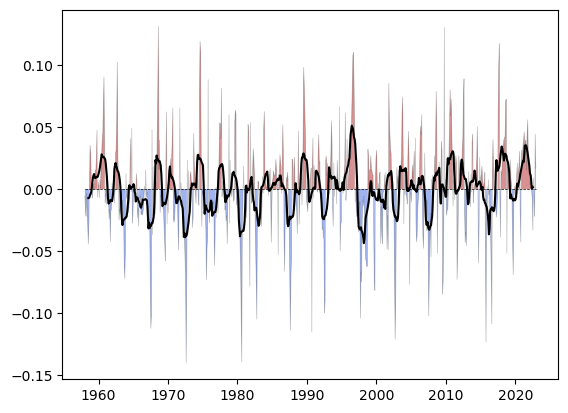

In [32]:
plt.figure()
plt.plot(I_ind_pos.coords['time'], I_ind_pos, color='k', linewidth=0.5, linestyle='-', alpha=0.25)
plt.plot(I_ind_pos.coords['time'], I_ind_pos*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0)
plt.plot(I_ind_pos.coords['time'], I_ind_pos.rolling(time=12, center=True).mean(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.fill_between(I_ind_pos.coords['time'], I_ind_pos.where(I_ind_pos > 0.0, other=np.nan), alpha=0.5, facecolor='firebrick')
plt.fill_between(I_ind_pos.coords['time'], I_ind_pos.where(I_ind_pos < 0.0, other=np.nan), alpha=0.5, facecolor='royalblue')

plt.figure()
plt.plot(I_ind_neg.coords['time'], I_ind_neg, color='k', linewidth=0.5, linestyle='-', alpha=0.25)
plt.plot(I_ind_neg.coords['time'], I_ind_neg*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0)
plt.plot(I_ind_neg.coords['time'], I_ind_neg.rolling(time=12, center=True).mean(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.fill_between(I_ind_neg.coords['time'], I_ind_neg.where(I_ind_neg > 0.0, other=np.nan), alpha=0.5, facecolor='firebrick')
plt.fill_between(I_ind_neg.coords['time'], I_ind_neg.where(I_ind_neg < 0.0, other=np.nan), alpha=0.5, facecolor='royalblue')

plt.figure()
plt.plot(I_pac_pos.coords['time'], I_pac_pos, color='k', linewidth=0.5, linestyle='-', alpha=0.25)
plt.plot(I_pac_pos.coords['time'], I_pac_pos*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0)
plt.plot(I_pac_pos.coords['time'], I_pac_pos.rolling(time=12, center=True).mean(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.fill_between(I_pac_pos.coords['time'], I_pac_pos.where(I_pac_pos > 0.0, other=np.nan), alpha=0.5, facecolor='firebrick')
plt.fill_between(I_pac_pos.coords['time'], I_pac_pos.where(I_pac_pos < 0.0, other=np.nan), alpha=0.5, facecolor='royalblue')

plt.figure()
plt.plot(I_pac_neg.coords['time'], I_pac_neg, color='k', linewidth=0.5, linestyle='-', alpha=0.25)
plt.plot(I_pac_neg.coords['time'], I_pac_neg*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0)
plt.plot(I_pac_neg.coords['time'], I_pac_neg.rolling(time=12, center=True).mean(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.fill_between(I_pac_neg.coords['time'], I_pac_neg.where(I_pac_neg > 0.0, other=np.nan), alpha=0.5, facecolor='firebrick')
plt.fill_between(I_pac_neg.coords['time'], I_pac_neg.where(I_pac_neg < 0.0, other=np.nan), alpha=0.5, facecolor='royalblue')


Text(0.05, 1.05, 'j')

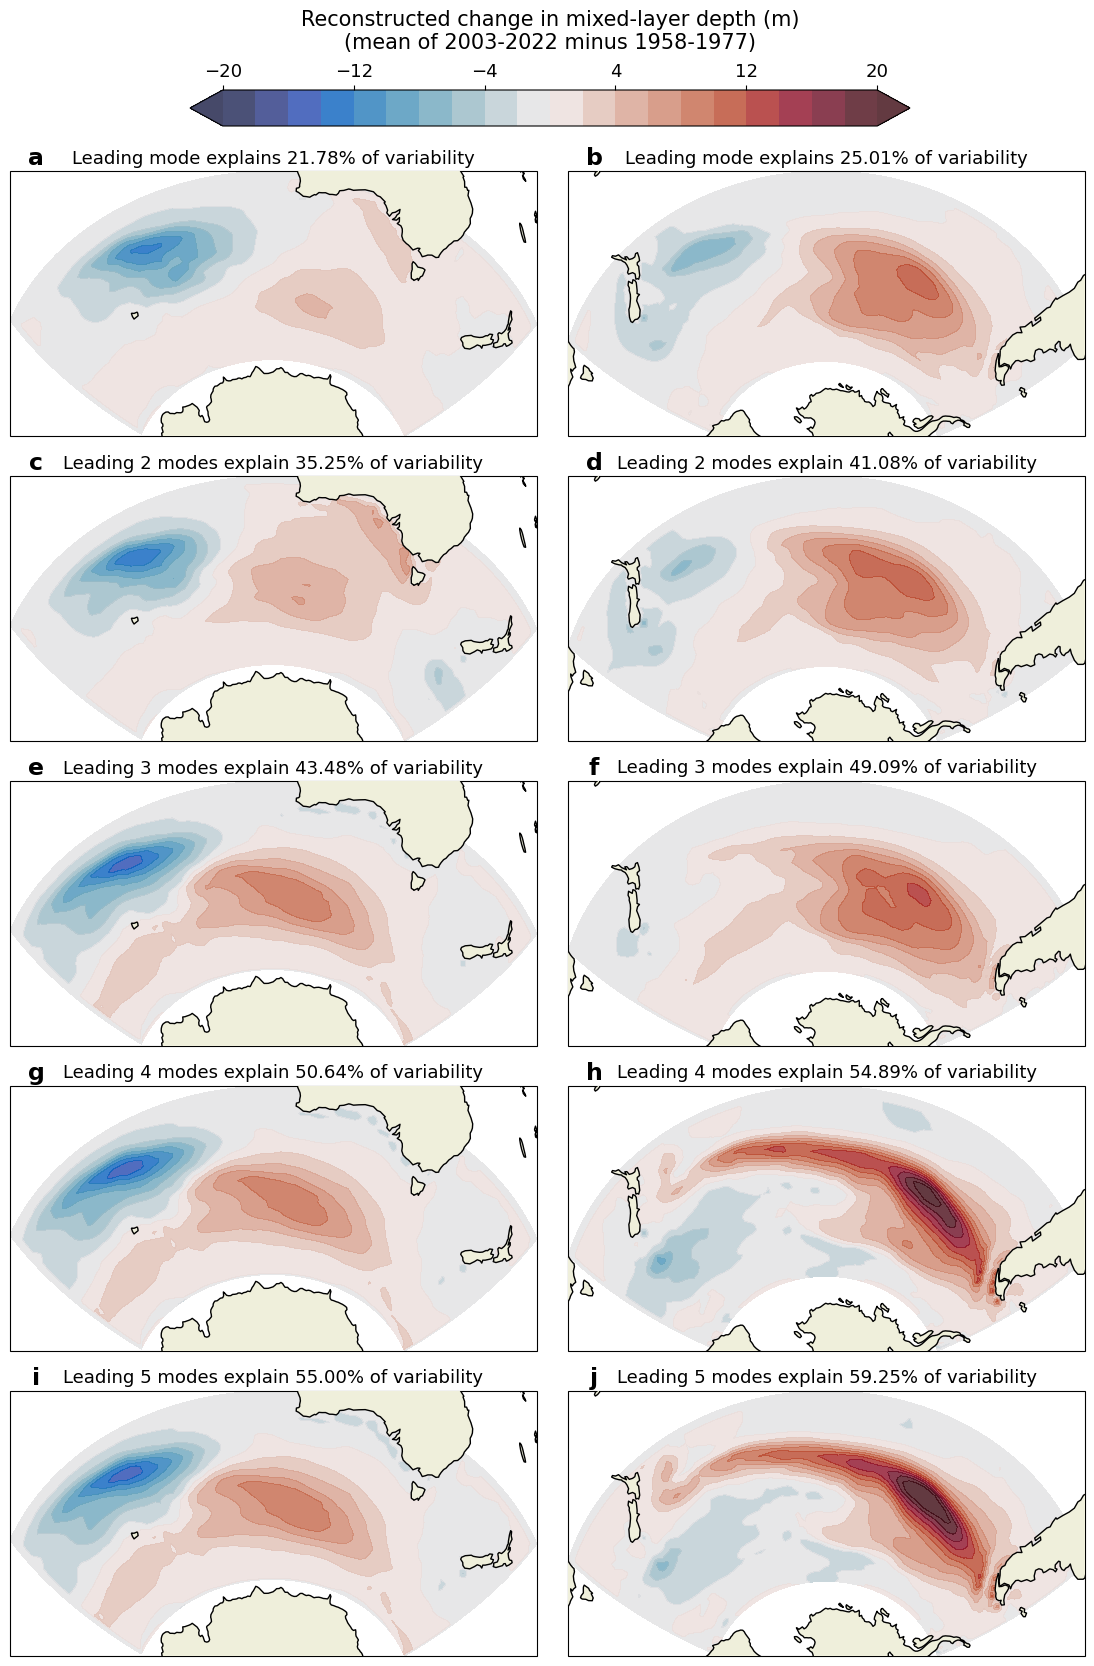

In [28]:
#%% Figure 1 (but with increasing numbers of modes included in reconstruction)

sind_proj = ccrs.Orthographic(central_latitude=-55, central_longitude=110)
spac_proj = ccrs.Orthographic(central_latitude=-60, central_longitude=225)

paclons = U_pac_reg.coords['lon']
paclats = U_pac_reg.coords['lat']
indlons = U_ind_reg.coords['lon']
indlats = U_ind_reg.coords['lat']


levs = np.arange(-20,21,2)
colmap = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
wid = 1.0

fig = plt.figure(figsize=(12,18), facecolor='w')
gs = GridSpec(5,2)

ax1 = plt.subplot(gs[0,0], projection=sind_proj)
ax2 = plt.subplot(gs[0,1], projection=spac_proj)
ax3 = plt.subplot(gs[1,0], projection=sind_proj)
ax4 = plt.subplot(gs[1,1], projection=spac_proj)
ax5 = plt.subplot(gs[2,0], projection=sind_proj)
ax6 = plt.subplot(gs[2,1], projection=spac_proj)
ax7 = plt.subplot(gs[3,0], projection=sind_proj)
ax8 = plt.subplot(gs[3,1], projection=spac_proj)
ax9 = plt.subplot(gs[4,0], projection=sind_proj)
ax10 = plt.subplot(gs[4,1], projection=spac_proj)

ax1.add_feature(cfeature.LAND, zorder=3)
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3)
ax2.add_feature(cfeature.COASTLINE, zorder=3)
ax3.add_feature(cfeature.LAND, zorder=3)
ax3.add_feature(cfeature.COASTLINE, zorder=3)
ax4.add_feature(cfeature.LAND, zorder=3)
ax4.add_feature(cfeature.COASTLINE, zorder=3)
ax5.add_feature(cfeature.LAND, zorder=3)
ax5.add_feature(cfeature.COASTLINE, zorder=3)
ax6.add_feature(cfeature.LAND, zorder=3)
ax6.add_feature(cfeature.COASTLINE, zorder=3)
ax7.add_feature(cfeature.LAND, zorder=3)
ax7.add_feature(cfeature.COASTLINE, zorder=3)
ax8.add_feature(cfeature.LAND, zorder=3)
ax8.add_feature(cfeature.COASTLINE, zorder=3)
ax9.add_feature(cfeature.LAND, zorder=3)
ax9.add_feature(cfeature.COASTLINE, zorder=3)
ax10.add_feature(cfeature.LAND, zorder=3)
ax10.add_feature(cfeature.COASTLINE, zorder=3)


p1 = ax1.contourf(indlons,indlats, X_ind_reconstructed.sel(mode=0).isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_ind_reconstructed.sel(mode=0).isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p2 = ax2.contourf(paclons,paclats, X_pac_reconstructed.sel(mode=0).isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_pac_reconstructed.sel(mode=0).isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')

plt.text(0.5,1.05,'Leading mode explains %.2f%% of variability'%(VE_ind.cumsum().sel(mode=0).values*100), transform=ax1.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading mode explains %.2f%% of variability'%(VE_pac.cumsum().sel(mode=0).values*100), transform=ax2.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 1 
p3 = ax3.contourf(indlons,indlats, X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p4 = ax4.contourf(paclons,paclats, X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')

plt.text(0.5,1.05,'Leading %i modes explain %.2f%% of variability'%(imodes+1, VE_ind.cumsum().sel(mode=imodes).values*100), transform=ax3.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading %i modes explain %.2f%% of variability'%(imodes+1, VE_pac.cumsum().sel(mode=imodes).values*100), transform=ax4.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 2
p5 = ax5.contourf(indlons,indlats, X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p6 = ax6.contourf(paclons,paclats, X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')

plt.text(0.5,1.05,'Leading %i modes explain %.2f%% of variability'%(imodes+1, VE_ind.cumsum().sel(mode=imodes).values*100), transform=ax5.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading %i modes explain %.2f%% of variability'%(imodes+1, VE_pac.cumsum().sel(mode=imodes).values*100), transform=ax6.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 3
p7 = ax7.contourf(indlons,indlats, X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p8 = ax8.contourf(paclons,paclats, X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')

plt.text(0.5,1.05,'Leading %i modes explain %.2f%% of variability'%(imodes+1, VE_ind.cumsum().sel(mode=imodes).values*100), transform=ax7.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading %i modes explain %.2f%% of variability'%(imodes+1, VE_pac.cumsum().sel(mode=imodes).values*100), transform=ax8.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 4
p9 = ax9.contourf(indlons,indlats, X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_ind_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p10 = ax10.contourf(paclons,paclats, X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(-240,-1)).mean(dim="time") - \
                  X_pac_reconstructed.sel(mode=slice(0,imodes)).sum(dim='mode').isel(time=slice(0,240)).mean(dim="time"), \
                  transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')

plt.text(0.5,1.05,'Leading %i modes explain %.2f%% of variability'%(imodes+1, VE_ind.cumsum().sel(mode=imodes).values*100), transform=ax9.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading %i modes explain %.2f%% of variability'%(imodes+1, VE_pac.cumsum().sel(mode=imodes).values*100), transform=ax10.transAxes, va='center', ha='center', fontsize=fstic)


cbax = fig.add_axes([0.2,0.9,0.6,0.02])
cbar1 = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::4])
cbar1.ax.tick_params(labelsize=fstic, labelbottom=False, bottom=False, labeltop=True, top=True)
cbar1.ax.set_xlabel('Reconstructed change in mixed-layer depth (m)\n(mean of 2003-2022 minus 1958-1977)', fontsize=fslab, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')

plt.subplots_adjust(left=0.05, top=0.875, right=0.95, bottom=0.05, wspace=0.05, hspace=0.15)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes)



In [354]:

fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_reconstruction_modes.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_reconstruction_modes.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-mld_reconstruction_modes_trans.png', dpi=300, bbox_inches='tight', transparent=True)


## make Supplementary Figure 1

### get the climate mode data and the leading PC of the Pacific SAM

In [94]:
dates = pd.date_range("1958-01", periods=65*12, freq="MS") + pd.offsets.Day(14)

enso = pd.read_excel('/home/pbuchanan/analysis_samw/ENSO_noaa.xlsx')         # https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
sam = pd.read_excel('/home/pbuchanan/analysis_samw/SAM_bas.xlsx')            # https://legacy.bas.ac.uk/met/gjma/sam.html   
pdo = pd.read_table('/home/pbuchanan/analysis_samw/IPO.txt', delimiter=',')  # https://www.ncei.noaa.gov/access/monitoring/pdo/
pdo[pdo == 99.99] = np.nan


file = "/home/pbuchanan/analysis_samw/pca.jra.55.hgt.500.1958010100_2023123118.anom.E000-360.S090-N000.N_66.L_0.mat" # PCs of z500 anomaly
with h5py.File(file, 'r') as f:
    print(list(f.keys())) # list variables
    pca_group = f['pca']
    print(list(pca_group.keys()))
    lon = pca_group['lon'][:]
    lat = pca_group['lat'][:]
    time = pca_group['time'][:]
    EIGs = pca_group['EIGs'][:]
    EOFs = pca_group['EOFs'][:]
    PCs = pca_group['PCs'][:]

# Function to convert float year to datetime64[ns]
def float_year_to_datetime(float_years):
    # Extract integer year
    years = float_years.astype(int)
    # Calculate fractional part
    fractional_part = float_years - years
    # Calculate days in the year (leap year check)
    days_in_year = np.array([366 if pd.Timestamp(f"{year}-01-01").is_leap_year else 365 for year in years])
    # Convert fractional part to days
    days = (fractional_part * days_in_year).astype(int)
    # Convert to datetime64
    datetimes = np.array([pd.Timestamp(f"{year}-01-01") + pd.to_timedelta(day, unit="D") for year, day in zip(years, days)])
    return datetimes

# times in datetime64[ns] format
tt = float_year_to_datetime(time[0,:])
# put leading PC in its own xarray dataarray
spac_z500_PC1 = xr.DataArray(
    PCs[0,:], 
    coords={"time": tt}, 
    dims=["time"]
)
spac_z500_PC2 = xr.DataArray(
    PCs[1,:], 
    coords={"time": tt}, 
    dims=["time"]
)
spac_z500_PC3 = xr.DataArray(
    PCs[2,:], 
    coords={"time": tt}, 
    dims=["time"]
)
spac_z500_PC4 = xr.DataArray(
    PCs[3,:], 
    coords={"time": tt}, 
    dims=["time"]
)
spac_z500_PC5 = xr.DataArray(
    PCs[4,:], 
    coords={"time": tt}, 
    dims=["time"]
)
# calculate the annual rolling mean on monthly mean
spac_z500_PC1 = spac_z500_PC1.resample(time="ME").mean()
spac_z500_PC2 = spac_z500_PC2.resample(time="ME").mean()
spac_z500_PC3 = spac_z500_PC3.resample(time="ME").mean()
spac_z500_PC4 = spac_z500_PC4.resample(time="ME").mean()
spac_z500_PC5 = spac_z500_PC5.resample(time="ME").mean()
# shift the time axis back to midpoint of each month
mid_month_time = spac_z500_PC1['time'] - pd.to_timedelta(spac_z500_PC1['time'].dt.daysinmonth // 2, unit="D")
spac_z500_PC1 = spac_z500_PC1.assign_coords(time=mid_month_time)
spac_z500_PC1_rolling = spac_z500_PC1.rolling(time=12, center=True).mean()
spac_z500_PC2 = spac_z500_PC2.assign_coords(time=mid_month_time)
spac_z500_PC2_rolling = spac_z500_PC2.rolling(time=12, center=True).mean()
spac_z500_PC3 = spac_z500_PC3.assign_coords(time=mid_month_time)
spac_z500_PC3_rolling = spac_z500_PC3.rolling(time=12, center=True).mean()
spac_z500_PC4 = spac_z500_PC4.assign_coords(time=mid_month_time)
spac_z500_PC4_rolling = spac_z500_PC4.rolling(time=12, center=True).mean()
spac_z500_PC5 = spac_z500_PC5.assign_coords(time=mid_month_time)
spac_z500_PC5_rolling = spac_z500_PC5.rolling(time=12, center=True).mean()



['#refs#', 'pca']
['EIGs', 'EOFs', 'N_save', 'N_trunc', 'PCs', 'SSE', 'detrend', 'extreme', 'hilbert', 'lags', 'lat', 'lon', 'mask', 'meta', 'norm_str', 'save_file', 'season', 'sum_of_lambdas', 'tendency', 'time', 'varexpl', 'variables', 'variance', 'weights', 'ymd']


### Calculate the combined index of the PSA1 + PSA2 for the Pacific and the PSA3 + PSA4 for the Indian

In [95]:
I_PSA_pac_pos = (spac_z500_PC2 * EIGs[0][1] + spac_z500_PC3 * EIGs[0][2]) / ((EIGs[0][1])**2 + (EIGs[0][2])**2)**0.5
I_PSA_ind_pos = (spac_z500_PC4 * EIGs[0][3] + spac_z500_PC5 * EIGs[0][4]) / ((EIGs[0][3])**2 + (EIGs[0][4])**2)**0.5
I_PSA_pac_neg = (spac_z500_PC2 * EIGs[0][1] - spac_z500_PC3 * EIGs[0][2]) / ((EIGs[0][1])**2 + (EIGs[0][2])**2)**0.5
I_PSA_ind_neg = (spac_z500_PC4 * EIGs[0][3] - spac_z500_PC5 * EIGs[0][4]) / ((EIGs[0][3])**2 + (EIGs[0][4])**2)**0.5


Text(0.05, 0.95, 'I(PSA4-PSA5) ~ I$_+$ (Indian)')

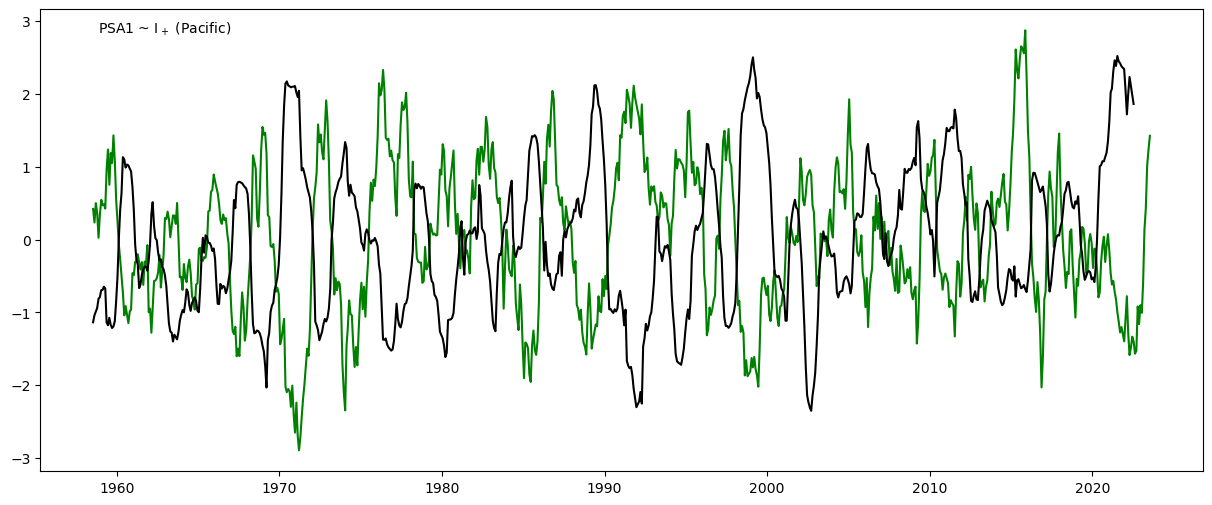

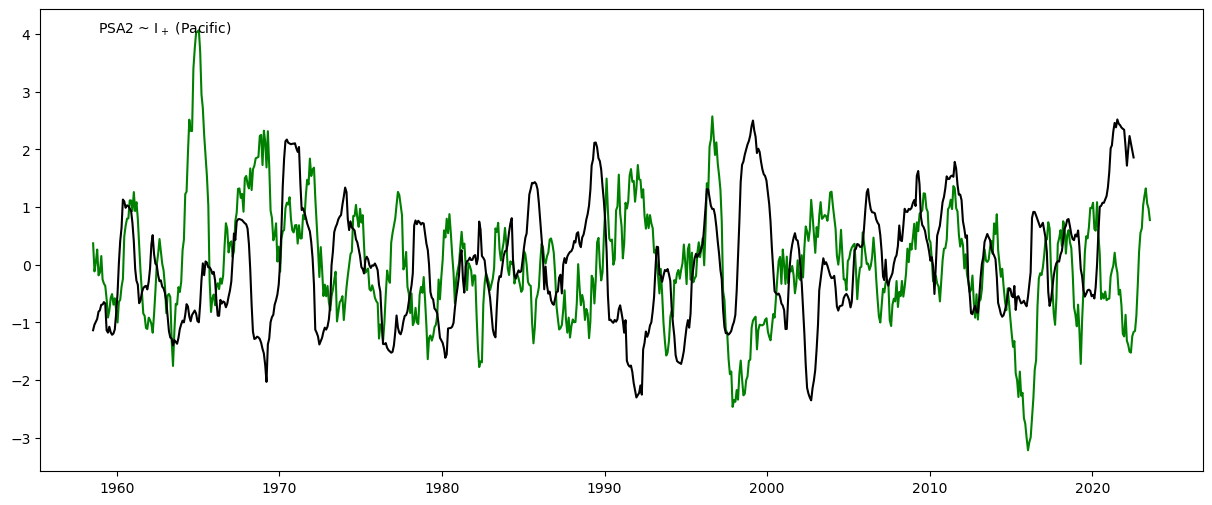

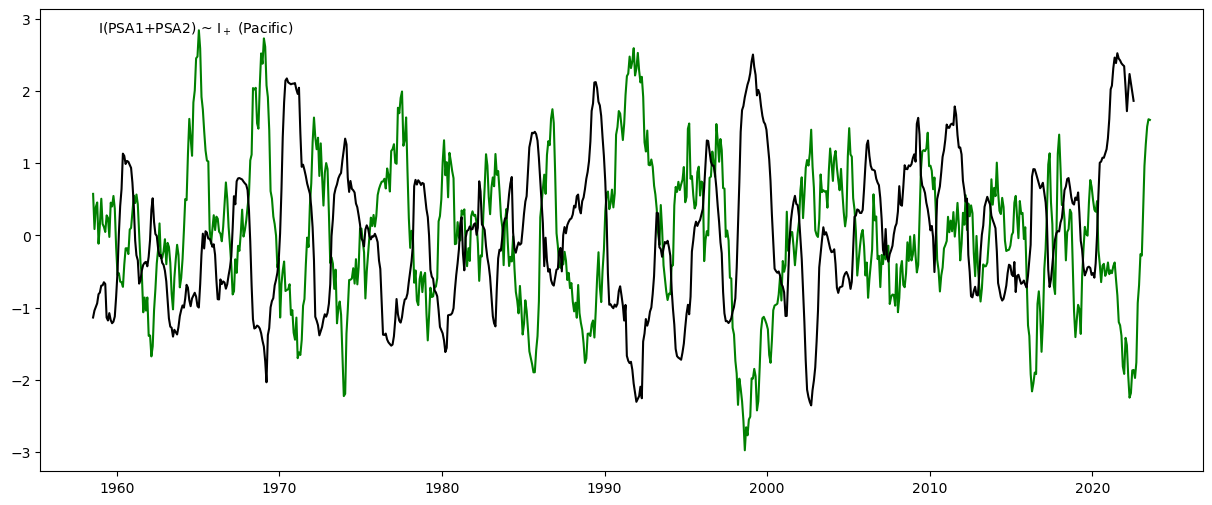

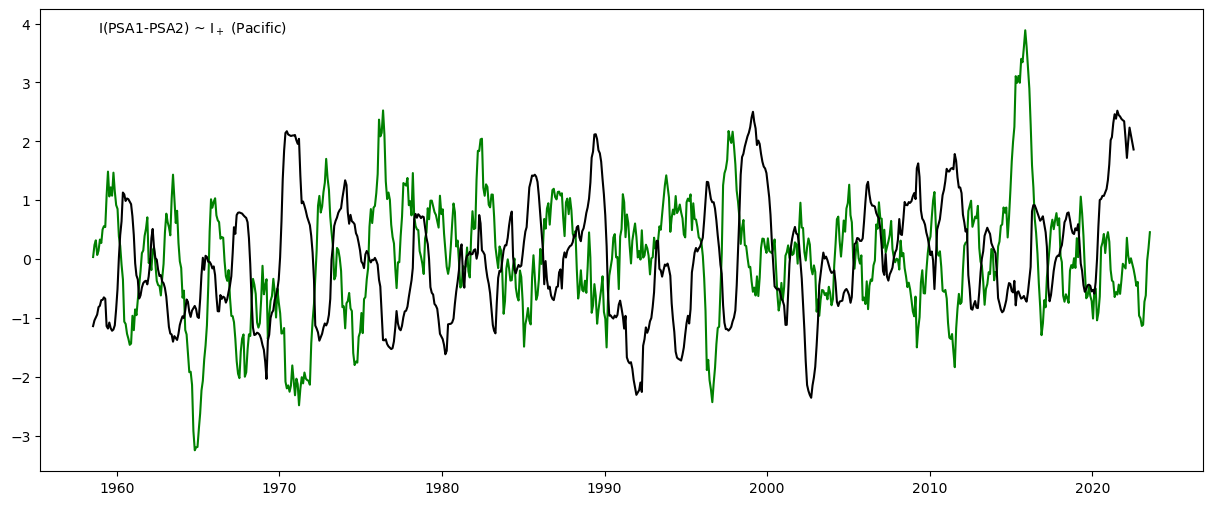

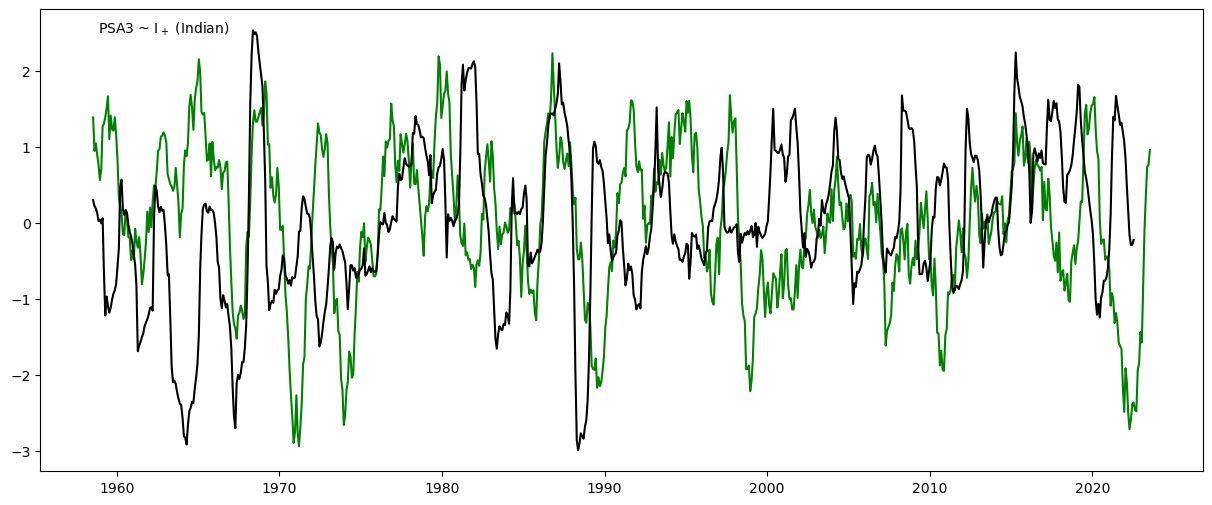

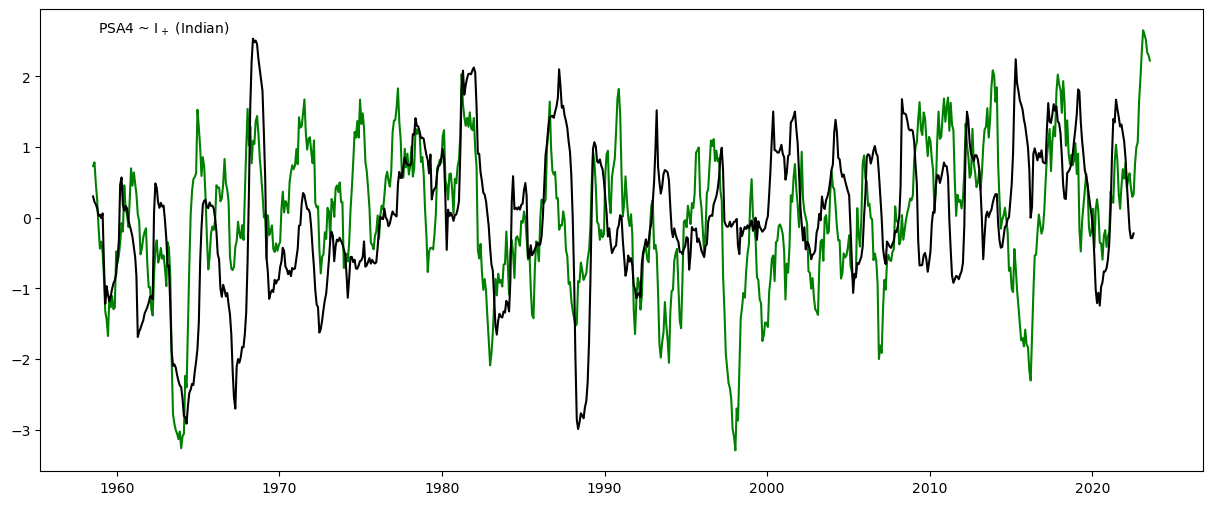

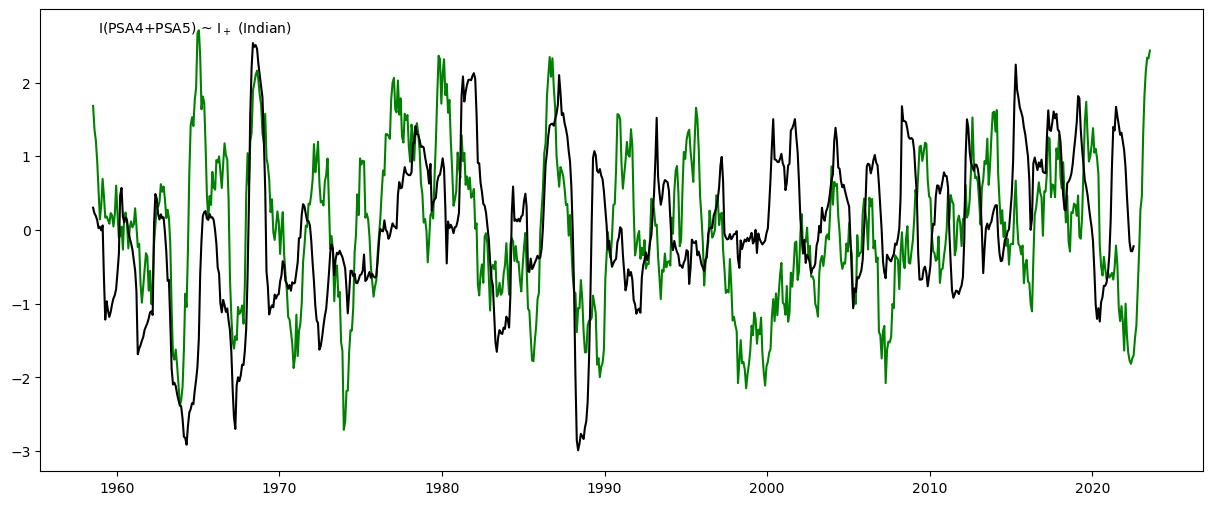

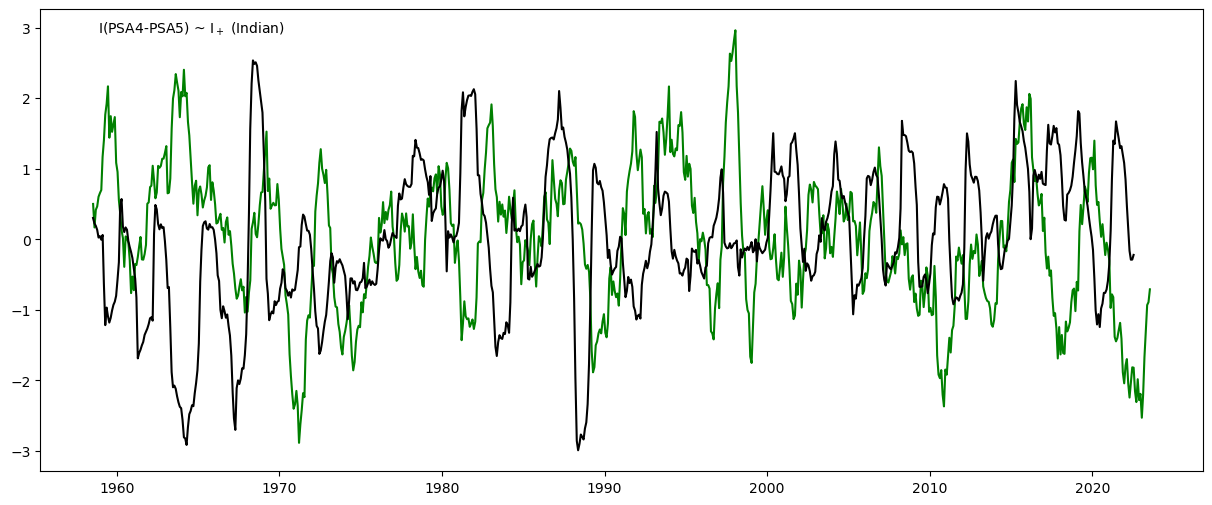

In [96]:
I_PSA_pac_pos_rolling = I_PSA_pac_pos.rolling(time=12, center=True).mean()
I_PSA_ind_pos_rolling = I_PSA_ind_pos.rolling(time=12, center=True).mean()
I_PSA_pac_neg_rolling = I_PSA_pac_neg.rolling(time=12, center=True).mean()
I_PSA_ind_neg_rolling = I_PSA_ind_neg.rolling(time=12, center=True).mean()

I_pac_pos_rolling = I_pac_pos.rolling(time=12, center=True).mean()
I_ind_pos_rolling = I_ind_pos.rolling(time=12, center=True).mean()

plt.figure(figsize=(15,6))
plt.plot(spac_z500_PC2_rolling.coords['time'], (spac_z500_PC2_rolling - spac_z500_PC2_rolling.mean()) / spac_z500_PC2_rolling.std(), color='g') 
plt.plot(I_pac_pos.coords['time'], (I_pac_pos_rolling - I_pac_pos_rolling.mean()) / I_pac_pos_rolling.std(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.text(0.05,0.95, "PSA1 ~ I$_+$ (Pacific)", transform=plt.gca().transAxes)

plt.figure(figsize=(15,6))
plt.plot(spac_z500_PC3_rolling.coords['time'], (spac_z500_PC3_rolling - spac_z500_PC3_rolling.mean()) / spac_z500_PC3_rolling.std(), color='g') 
plt.plot(I_pac_pos.coords['time'], (I_pac_pos_rolling - I_pac_pos_rolling.mean()) / I_pac_pos_rolling.std(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.text(0.05,0.95, "PSA2 ~ I$_+$ (Pacific)", transform=plt.gca().transAxes)

plt.figure(figsize=(15,6))
plt.plot(I_PSA_pac_pos_rolling.coords['time'], (I_PSA_pac_pos_rolling - I_PSA_pac_pos_rolling.mean()) / I_PSA_pac_pos_rolling.std(), color='g') 
plt.plot(I_pac_pos.coords['time'], (I_pac_pos_rolling - I_pac_pos_rolling.mean()) / I_pac_pos_rolling.std(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.text(0.05,0.95, "I(PSA1+PSA2) ~ I$_+$ (Pacific)", transform=plt.gca().transAxes)

plt.figure(figsize=(15,6))
plt.plot(I_PSA_pac_neg_rolling.coords['time'], (I_PSA_pac_neg_rolling - I_PSA_pac_neg_rolling.mean()) / I_PSA_pac_neg_rolling.std(), color='g') 
plt.plot(I_pac_pos.coords['time'], (I_pac_pos_rolling - I_pac_pos_rolling.mean()) / I_pac_pos_rolling.std(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.text(0.05,0.95, "I(PSA1-PSA2) ~ I$_+$ (Pacific)", transform=plt.gca().transAxes)

plt.figure(figsize=(15,6))
plt.plot(spac_z500_PC4_rolling.coords['time'], (spac_z500_PC4_rolling - spac_z500_PC4_rolling.mean()) / spac_z500_PC4_rolling.std(), color='g') 
plt.plot(I_ind_pos.coords['time'], (I_ind_pos_rolling - I_ind_pos_rolling.mean()) / I_ind_pos_rolling.std(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.text(0.05,0.95, "PSA3 ~ I$_+$ (Indian)", transform=plt.gca().transAxes)

plt.figure(figsize=(15,6))
plt.plot(spac_z500_PC5_rolling.coords['time'], (spac_z500_PC5_rolling - spac_z500_PC5_rolling.mean()) / spac_z500_PC5_rolling.std(), color='g') 
plt.plot(I_ind_pos.coords['time'], (I_ind_pos_rolling - I_ind_pos_rolling.mean()) / I_ind_pos_rolling.std(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.text(0.05,0.95, "PSA4 ~ I$_+$ (Indian)", transform=plt.gca().transAxes)

plt.figure(figsize=(15,6))
plt.plot(I_PSA_ind_pos_rolling.coords['time'], (I_PSA_ind_pos_rolling - I_PSA_ind_pos_rolling.mean()) / I_PSA_ind_pos_rolling.std(), color='g') 
plt.plot(I_ind_pos.coords['time'], (I_ind_pos_rolling - I_ind_pos_rolling.mean()) / I_ind_pos_rolling.std(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.text(0.05,0.95, "I(PSA4+PSA5) ~ I$_+$ (Indian)", transform=plt.gca().transAxes)

plt.figure(figsize=(15,6))
plt.plot(I_PSA_ind_neg_rolling.coords['time'], (I_PSA_ind_neg_rolling - I_PSA_ind_neg_rolling.mean()) / I_PSA_ind_neg_rolling.std(), color='g') 
plt.plot(I_ind_pos.coords['time'], (I_ind_pos_rolling - I_ind_pos_rolling.mean()) / I_ind_pos_rolling.std(), color='k', linewidth=1.5, linestyle='-', label="12 month running mean")
plt.text(0.05,0.95, "I(PSA4-PSA5) ~ I$_+$ (Indian)", transform=plt.gca().transAxes)



### 12 month running means

In [97]:

# 12-month running mean for SAM
sam_ts = []
for yr in np.arange(1957,2024,1):
    for mn in np.arange(1,13,1):
        sam_ts.append(sam[sam['Year']==yr].values[0][mn])
sam_ts = pd.DataFrame(np.array(sam_ts)).dropna()
sam_ts = sam_ts.rolling(window=12, center=True).mean()[12:792]

# get ENSO timeseries too
enso_ts = []
for yr in np.arange(1958,2023,1):
    for mn in np.arange(1,13,1):
        enso_ts.append(enso[enso['Year']==yr].values[0][mn])

# 12-month running mean of PDO timeseries
pdo_ts = []
for yr in np.arange(1957,2023,1):
    for mn in np.arange(1,13,1):
        pdo_ts.append(pdo[pdo['Year']==yr].values[0][mn])
pdo_ts = pd.DataFrame(np.array(pdo_ts)).dropna()
pdo_ts = pdo_ts.rolling(window=12, center=True).mean()[12:787]

enso_ts = np.array(enso_ts)
sam_ts = np.array(sam_ts).squeeze()
pdo_ts = np.array(pdo_ts).squeeze()
z500_PC1_ts = np.array(spac_z500_PC1_rolling).squeeze()[0:-12]
z500_PC2_ts = np.array(spac_z500_PC2_rolling).squeeze()[0:-12]
z500_PC3_ts = np.array(spac_z500_PC3_rolling).squeeze()[0:-12]
z500_PC4_ts = np.array(spac_z500_PC4_rolling).squeeze()[0:-12]
z500_PC5_ts = np.array(spac_z500_PC5_rolling).squeeze()[0:-12]
I_PSA_pac_pos_ts = np.array(I_PSA_pac_pos_rolling).squeeze()[0:-12]
I_PSA_pac_neg_ts = np.array(I_PSA_pac_neg_rolling).squeeze()[0:-12]
I_PSA_ind_pos_ts = np.array(I_PSA_ind_pos_rolling).squeeze()[0:-12]
I_PSA_ind_neg_ts = np.array(I_PSA_ind_neg_rolling).squeeze()[0:-12]




### try correlations

In [98]:
ind_pos = I_ind_pos.rolling(time=12, center=True).mean()
pac_pos = I_pac_pos.rolling(time=12, center=True).mean()
ind_neg = I_ind_neg.rolling(time=12, center=True).mean()
pac_neg = I_pac_neg.rolling(time=12, center=True).mean()

pac_m1 = S_pac.sel(mode=0) * V_pac.sel(mode=0).T 
pac_m2 = S_pac.sel(mode=1) * V_pac.sel(mode=1).T 
ind_m1 = S_ind.sel(mode=0) * V_ind.sel(mode=0).T 
ind_m2 = S_ind.sel(mode=1) * V_ind.sel(mode=1).T 

# Normalize

ind_pos = (ind_pos - ind_pos.mean()) / ind_pos.std()
pac_pos = (pac_pos - pac_pos.mean()) / pac_pos.std()
ind_neg = (ind_neg - ind_neg.mean()) / ind_neg.std()
pac_neg = (pac_neg - pac_neg.mean()) / pac_neg.std()
ind_m1 = (ind_m1 - ind_m1.mean()) / ind_m1.std()
pac_m1 = (pac_m1 - pac_m1.mean()) / pac_m1.std()
ind_m2 = (ind_m2 - ind_m2.mean()) / ind_m2.std()
pac_m2 = (pac_m2 - pac_m2.mean()) / pac_m2.std()
z500_PC1_ts = (z500_PC1_ts - np.nanmean(z500_PC1_ts))/ np.nanstd(z500_PC1_ts)
z500_PC2_ts = (z500_PC2_ts - np.nanmean(z500_PC2_ts))/ np.nanstd(z500_PC2_ts)
z500_PC3_ts = (z500_PC3_ts - np.nanmean(z500_PC3_ts))/ np.nanstd(z500_PC3_ts)
z500_PC4_ts = (z500_PC4_ts - np.nanmean(z500_PC4_ts))/ np.nanstd(z500_PC4_ts)
z500_PC5_ts = (z500_PC5_ts - np.nanmean(z500_PC5_ts))/ np.nanstd(z500_PC5_ts)
I_PSA_pac_pos_ts = (I_PSA_pac_pos_ts - np.nanmean(I_PSA_pac_pos_ts)) / np.nanstd(I_PSA_pac_pos_ts)
I_PSA_pac_neg_ts = (I_PSA_pac_neg_ts - np.nanmean(I_PSA_pac_neg_ts)) / np.nanstd(I_PSA_pac_neg_ts)
I_PSA_ind_pos_ts = (I_PSA_ind_pos_ts - np.nanmean(I_PSA_ind_pos_ts)) / np.nanstd(I_PSA_ind_pos_ts)
I_PSA_ind_neg_ts = (I_PSA_ind_neg_ts - np.nanmean(I_PSA_ind_neg_ts)) / np.nanstd(I_PSA_ind_neg_ts)


# add Pearson correlations
import scipy.stats as sci
enso_pac_m1_r = sci.pearsonr(pac_m1[~np.isnan(pac_m1)],enso_ts[~np.isnan(pac_m1)])  # PC1 of MLDa vs. ENSO
enso_pac_m2_r = sci.pearsonr(pac_m2[~np.isnan(pac_m2)],enso_ts[~np.isnan(pac_m2)])  # PC2 of MLDa vs. ENSO
enso_pac_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],enso_ts[~np.isnan(pac_pos)])  # I(+) of MLDa vs. ENSO
enso_pac_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],enso_ts[~np.isnan(pac_neg)])  # I(-) of MLDa vs. ENSO

enso_ind_m1_r = sci.pearsonr(ind_m1[~np.isnan(ind_m1)],enso_ts[~np.isnan(ind_m1)])
enso_ind_m2_r = sci.pearsonr(ind_m2[~np.isnan(ind_m2)],enso_ts[~np.isnan(ind_m2)])
enso_ind_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],enso_ts[~np.isnan(ind_pos)])
enso_ind_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],enso_ts[~np.isnan(ind_neg)])

sam_pac_m1_r = sci.pearsonr(pac_m1[~np.isnan(pac_m1)],sam_ts[~np.isnan(pac_m1)])
sam_pac_m2_r = sci.pearsonr(pac_m2[~np.isnan(pac_m2)],sam_ts[~np.isnan(pac_m2)])
sam_pac_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],sam_ts[~np.isnan(pac_pos)])
sam_pac_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],sam_ts[~np.isnan(pac_neg)])

sam_ind_m1_r = sci.pearsonr(ind_m1[~np.isnan(ind_m1)],sam_ts[~np.isnan(ind_m1)])
sam_ind_m2_r = sci.pearsonr(ind_m2[~np.isnan(ind_m2)],sam_ts[~np.isnan(ind_m2)])
sam_ind_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],sam_ts[~np.isnan(ind_pos)])
sam_ind_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],sam_ts[~np.isnan(ind_neg)])

z500_PC1_pac_m1_r = sci.pearsonr(pac_m1[~np.isnan(z500_PC1_ts)],z500_PC1_ts[~np.isnan(z500_PC1_ts)])
z500_PC1_pac_m2_r = sci.pearsonr(pac_m2[~np.isnan(z500_PC1_ts)],z500_PC1_ts[~np.isnan(z500_PC1_ts)])
z500_PC1_pac_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],z500_PC1_ts[~np.isnan(pac_pos)])
z500_PC1_pac_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],z500_PC1_ts[~np.isnan(pac_neg)])

z500_PC1_ind_m1_r = sci.pearsonr(ind_m1[~np.isnan(z500_PC1_ts)],z500_PC1_ts[~np.isnan(z500_PC1_ts)])
z500_PC1_ind_m2_r = sci.pearsonr(ind_m2[~np.isnan(z500_PC1_ts)],z500_PC1_ts[~np.isnan(z500_PC1_ts)])
z500_PC1_ind_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],z500_PC1_ts[~np.isnan(ind_pos)])
z500_PC1_ind_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],z500_PC1_ts[~np.isnan(ind_neg)])

z500_PC2_pac_m1_r = sci.pearsonr(pac_m1[~np.isnan(z500_PC2_ts)],z500_PC2_ts[~np.isnan(z500_PC2_ts)])
z500_PC2_pac_m2_r = sci.pearsonr(pac_m2[~np.isnan(z500_PC2_ts)],z500_PC2_ts[~np.isnan(z500_PC2_ts)])
z500_PC2_pac_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],z500_PC2_ts[~np.isnan(pac_pos)])
z500_PC2_pac_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],z500_PC2_ts[~np.isnan(pac_neg)])

z500_PC2_ind_m1_r = sci.pearsonr(ind_m1[~np.isnan(z500_PC2_ts)],z500_PC2_ts[~np.isnan(z500_PC2_ts)])
z500_PC2_ind_m2_r = sci.pearsonr(ind_m2[~np.isnan(z500_PC2_ts)],z500_PC2_ts[~np.isnan(z500_PC2_ts)])
z500_PC2_ind_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],z500_PC2_ts[~np.isnan(ind_pos)])
z500_PC2_ind_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],z500_PC2_ts[~np.isnan(ind_neg)])

z500_PC3_pac_m1_r = sci.pearsonr(pac_m1[~np.isnan(z500_PC3_ts)],z500_PC3_ts[~np.isnan(z500_PC3_ts)])
z500_PC3_pac_m2_r = sci.pearsonr(pac_m2[~np.isnan(z500_PC3_ts)],z500_PC3_ts[~np.isnan(z500_PC3_ts)])
z500_PC3_pac_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],z500_PC3_ts[~np.isnan(pac_pos)])
z500_PC3_pac_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],z500_PC3_ts[~np.isnan(pac_neg)])

z500_PC3_ind_m1_r = sci.pearsonr(ind_m1[~np.isnan(z500_PC3_ts)],z500_PC3_ts[~np.isnan(z500_PC3_ts)])
z500_PC3_ind_m2_r = sci.pearsonr(ind_m2[~np.isnan(z500_PC3_ts)],z500_PC3_ts[~np.isnan(z500_PC3_ts)])
z500_PC3_ind_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],z500_PC3_ts[~np.isnan(ind_pos)])
z500_PC3_ind_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],z500_PC3_ts[~np.isnan(ind_neg)])

z500_PC4_pac_m1_r = sci.pearsonr(pac_m1[~np.isnan(z500_PC4_ts)],z500_PC4_ts[~np.isnan(z500_PC4_ts)])
z500_PC4_pac_m2_r = sci.pearsonr(pac_m2[~np.isnan(z500_PC4_ts)],z500_PC4_ts[~np.isnan(z500_PC4_ts)])
z500_PC4_pac_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],z500_PC4_ts[~np.isnan(pac_pos)])
z500_PC4_pac_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],z500_PC4_ts[~np.isnan(pac_neg)])

z500_PC4_ind_m1_r = sci.pearsonr(ind_m1[~np.isnan(z500_PC4_ts)],z500_PC4_ts[~np.isnan(z500_PC4_ts)])
z500_PC4_ind_m2_r = sci.pearsonr(ind_m2[~np.isnan(z500_PC4_ts)],z500_PC4_ts[~np.isnan(z500_PC4_ts)])
z500_PC4_ind_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],z500_PC4_ts[~np.isnan(ind_pos)])
z500_PC4_ind_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],z500_PC4_ts[~np.isnan(ind_neg)])

z500_PC5_pac_m1_r = sci.pearsonr(pac_m1[~np.isnan(z500_PC5_ts)],z500_PC5_ts[~np.isnan(z500_PC5_ts)])
z500_PC5_pac_m2_r = sci.pearsonr(pac_m2[~np.isnan(z500_PC5_ts)],z500_PC5_ts[~np.isnan(z500_PC5_ts)])
z500_PC5_pac_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],z500_PC5_ts[~np.isnan(pac_pos)])
z500_PC5_pac_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],z500_PC5_ts[~np.isnan(pac_neg)])

z500_PC5_ind_m1_r = sci.pearsonr(ind_m1[~np.isnan(z500_PC5_ts)],z500_PC5_ts[~np.isnan(z500_PC5_ts)])
z500_PC5_ind_m2_r = sci.pearsonr(ind_m2[~np.isnan(z500_PC5_ts)],z500_PC5_ts[~np.isnan(z500_PC5_ts)])
z500_PC5_ind_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],z500_PC5_ts[~np.isnan(ind_pos)])
z500_PC5_ind_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],z500_PC5_ts[~np.isnan(ind_neg)])

I_PSA_pac_pos_m1_r = sci.pearsonr(pac_m1[~np.isnan(I_PSA_pac_pos_ts)],I_PSA_pac_pos_ts[~np.isnan(I_PSA_pac_pos_ts)]) # PC1 of MLDa vs. I(+) of Pac PSA
I_PSA_pac_pos_m2_r = sci.pearsonr(pac_m2[~np.isnan(I_PSA_pac_pos_ts)],I_PSA_pac_pos_ts[~np.isnan(I_PSA_pac_pos_ts)]) # PC2 of MLDa vs. I(+) of Pac PSA
I_PSA_pac_pos_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],I_PSA_pac_pos_ts[~np.isnan(pac_pos)]) # I(+) of MLDa vs. I(+) of Pac PSA
I_PSA_pac_pos_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],I_PSA_pac_pos_ts[~np.isnan(pac_neg)]) # I(-) of MLDa vs. I(+) of Pac PSA

I_PSA_pac_neg_m1_r = sci.pearsonr(pac_m1[~np.isnan(I_PSA_pac_neg_ts)],I_PSA_pac_neg_ts[~np.isnan(I_PSA_pac_neg_ts)])
I_PSA_pac_neg_m2_r = sci.pearsonr(pac_m2[~np.isnan(I_PSA_pac_neg_ts)],I_PSA_pac_neg_ts[~np.isnan(I_PSA_pac_neg_ts)])
I_PSA_pac_neg_pos_r = sci.pearsonr(pac_pos[~np.isnan(pac_pos)],I_PSA_pac_neg_ts[~np.isnan(pac_pos)])
I_PSA_pac_neg_neg_r = sci.pearsonr(pac_neg[~np.isnan(pac_neg)],I_PSA_pac_neg_ts[~np.isnan(pac_neg)])

I_PSA_ind_pos_m1_r = sci.pearsonr(ind_m1[~np.isnan(I_PSA_ind_pos_ts)],I_PSA_ind_pos_ts[~np.isnan(I_PSA_ind_pos_ts)]) # PC1 of MLDa vs. I(+) of Pac PSA
I_PSA_ind_pos_m2_r = sci.pearsonr(ind_m2[~np.isnan(I_PSA_ind_pos_ts)],I_PSA_ind_pos_ts[~np.isnan(I_PSA_ind_pos_ts)]) # PC2 of MLDa vs. I(+) of Pac PSA
I_PSA_ind_pos_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],I_PSA_ind_pos_ts[~np.isnan(ind_pos)]) # I(+) of MLDa vs. I(+) of Pac PSA
I_PSA_ind_pos_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],I_PSA_ind_pos_ts[~np.isnan(ind_neg)]) # I(-) of MLDa vs. I(+) of Pac PSA

I_PSA_ind_neg_m1_r = sci.pearsonr(ind_m1[~np.isnan(I_PSA_ind_neg_ts)],I_PSA_ind_neg_ts[~np.isnan(I_PSA_ind_neg_ts)])
I_PSA_ind_neg_m2_r = sci.pearsonr(ind_m2[~np.isnan(I_PSA_ind_neg_ts)],I_PSA_ind_neg_ts[~np.isnan(I_PSA_ind_neg_ts)])
I_PSA_ind_neg_pos_r = sci.pearsonr(ind_pos[~np.isnan(ind_pos)],I_PSA_ind_neg_ts[~np.isnan(ind_pos)])
I_PSA_ind_neg_neg_r = sci.pearsonr(ind_neg[~np.isnan(ind_neg)],I_PSA_ind_neg_ts[~np.isnan(ind_neg)])


print("correlation btw ENSO and Pacific 1st mode =", enso_pac_m1_r[0])
print("correlation btw ENSO and Pacific 2nd mode =", enso_pac_m2_r[0])
print("correlation btw ENSO and Pacific pos mode =", enso_pac_pos_r[0])
print("correlation btw ENSO and Pacific neg mode =", enso_pac_neg_r[0])
print(" ")
print("correlation btw ENSO and Indian 1st mode =", enso_ind_m1_r[0])
print("correlation btw ENSO and Indian 2nd mode =", enso_ind_m2_r[0])
print("correlation btw ENSO and Indian pos mode =", enso_ind_pos_r[0])
print("correlation btw ENSO and Indian neg mode =", enso_ind_neg_r[0])
print(" ")
print("correlation btw SAM and Pacific 1st mode =", sam_pac_m1_r[0])
print("correlation btw SAM and Pacific 2nd mode =", sam_pac_m2_r[0])
print("correlation btw SAM and Pacific pos mode =", sam_pac_pos_r[0])
print("correlation btw SAM and Pacific neg mode =", sam_pac_neg_r[0])
print(" ")
print("correlation btw SAM and Indian 1st mode =", sam_ind_m1_r[0])
print("correlation btw SAM and Indian 2nd mode =", sam_ind_m2_r[0])
print("correlation btw SAM and Indian pos mode =", sam_ind_pos_r[0])
print("correlation btw SAM and Indian neg mode =", sam_ind_neg_r[0])
print(" ")
print("correlation btw PSA1 and Pacific 1st mode =", z500_PC2_pac_m1_r[0])
print("correlation btw PSA1 and Pacific 2nd mode =", z500_PC2_pac_m2_r[0])
print("correlation btw PSA1 and Pacific pos mode =", z500_PC2_pac_pos_r[0])
print("correlation btw PSA1 and Pacific neg mode =", z500_PC2_pac_neg_r[0])
print(" ")
print("correlation btw PSA1 and Indian 1st mode =", z500_PC2_ind_m1_r[0])
print("correlation btw PSA1 and Indian 2nd mode =", z500_PC2_ind_m2_r[0])
print("correlation btw PSA1 and Indian pos mode =", z500_PC2_ind_pos_r[0])
print("correlation btw PSA1 and Indian neg mode =", z500_PC2_ind_neg_r[0])
print(" ")
print("correlation btw PSA2 and Pacific 1st mode =", z500_PC3_pac_m1_r[0])
print("correlation btw PSA2 and Pacific 2nd mode =", z500_PC3_pac_m2_r[0])
print("correlation btw PSA2 and Pacific pos mode =", z500_PC3_pac_pos_r[0])
print("correlation btw PSA2 and Pacific neg mode =", z500_PC3_pac_neg_r[0])
print(" ")
print("correlation btw PSA2 and Indian 1st mode =", z500_PC3_ind_m1_r[0])
print("correlation btw PSA2 and Indian 2nd mode =", z500_PC3_ind_m2_r[0])
print("correlation btw PSA2 and Indian pos mode =", z500_PC3_ind_pos_r[0])
print("correlation btw PSA2 and Indian neg mode =", z500_PC3_ind_neg_r[0])
print(" ")
print("correlation btw PSA3 and Pacific 1st mode =", z500_PC4_pac_m1_r[0])
print("correlation btw PSA3 and Pacific 2nd mode =", z500_PC4_pac_m2_r[0])
print("correlation btw PSA3 and Pacific pos mode =", z500_PC4_pac_pos_r[0])
print("correlation btw PSA3 and Pacific neg mode =", z500_PC4_pac_neg_r[0])
print(" ")
print("correlation btw PSA3 and Indian 1st mode =", z500_PC4_ind_m1_r[0])
print("correlation btw PSA3 and Indian 2nd mode =", z500_PC4_ind_m2_r[0])
print("correlation btw PSA3 and Indian pos mode =", z500_PC4_ind_pos_r[0])
print("correlation btw PSA3 and Indian neg mode =", z500_PC4_ind_neg_r[0])
print(" ")
print("correlation btw PSA4 and Pacific 1st mode =", z500_PC5_pac_m1_r[0])
print("correlation btw PSA4 and Pacific 2nd mode =", z500_PC5_pac_m2_r[0])
print("correlation btw PSA4 and Pacific pos mode =", z500_PC5_pac_pos_r[0])
print("correlation btw PSA4 and Pacific neg mode =", z500_PC5_pac_neg_r[0])
print(" ")
print("correlation btw PSA4 and Indian 1st mode =", z500_PC5_ind_m1_r[0])
print("correlation btw PSA4 and Indian 2nd mode =", z500_PC5_ind_m2_r[0])
print("correlation btw PSA4 and Indian pos mode =", z500_PC5_ind_pos_r[0])
print("correlation btw PSA4 and Indian neg mode =", z500_PC5_ind_neg_r[0])
print(" ")
print("correlation btw I(PSA+) and Pacific 1st mode =", I_PSA_pac_pos_m1_r[0])
print("correlation btw I(PSA+) and Pacific 2nd mode =", I_PSA_pac_pos_m2_r[0])
print("correlation btw I(PSA+) and Pacific pos mode =", I_PSA_pac_pos_pos_r[0])
print("correlation btw I(PSA+) and Pacific neg mode =", I_PSA_pac_pos_neg_r[0])
print(" ")
print("correlation btw I(PSA+) and Indian 1st mode =", I_PSA_ind_pos_m1_r[0])
print("correlation btw I(PSA+) and Indian 2nd mode =", I_PSA_ind_pos_m2_r[0])
print("correlation btw I(PSA+) and Indian pos mode =", I_PSA_ind_pos_pos_r[0])
print("correlation btw I(PSA+) and Indian neg mode =", I_PSA_ind_pos_neg_r[0])
print(" ")
print("correlation btw I(PSA-) and Pacific 1st mode =", I_PSA_pac_neg_m1_r[0])
print("correlation btw I(PSA-) and Pacific 2nd mode =", I_PSA_pac_neg_m2_r[0])
print("correlation btw I(PSA-) and Pacific pos mode =", I_PSA_pac_neg_pos_r[0])
print("correlation btw I(PSA-) and Pacific neg mode =", I_PSA_pac_neg_neg_r[0])
print(" ")
print("correlation btw I(PSA-) and Indian 1st mode =", I_PSA_ind_neg_m1_r[0])
print("correlation btw I(PSA-) and Indian 2nd mode =", I_PSA_ind_neg_m2_r[0])
print("correlation btw I(PSA-) and Indian pos mode =", I_PSA_ind_neg_pos_r[0])
print("correlation btw I(PSA-) and Indian neg mode =", I_PSA_ind_neg_neg_r[0])


correlation btw ENSO and Pacific 1st mode = -0.3566778946399925
correlation btw ENSO and Pacific 2nd mode = -0.1403976807745561
correlation btw ENSO and Pacific pos mode = -0.5866108642318122
correlation btw ENSO and Pacific neg mode = -0.33839885087020694
 
correlation btw ENSO and Indian 1st mode = -0.11043197034133649
correlation btw ENSO and Indian 2nd mode = 0.06416384668532764
correlation btw ENSO and Indian pos mode = 0.08829588571957203
correlation btw ENSO and Indian neg mode = 0.20110919419638174
 
correlation btw SAM and Pacific 1st mode = 0.2773953191979745
correlation btw SAM and Pacific 2nd mode = 0.12981462130277116
correlation btw SAM and Pacific pos mode = 0.43818046549779455
correlation btw SAM and Pacific neg mode = 0.23512816361941008
 
correlation btw SAM and Indian 1st mode = -0.23979465274878742
correlation btw SAM and Indian 2nd mode = 0.06096014004230464
correlation btw SAM and Indian pos mode = 0.3431094989291152
correlation btw SAM and Indian neg mode = 0.433

### let's try a rolling correlation on those fields that look correlated at least in the first 40 years of the hindcast

In [ ]:
import pandas as pd

# Example data
sam_series = pd.Series(sam_ts)
enso_series = pd.Series(enso_ts)


# Compute rolling correlation
rolling_corr = x_series.rolling(window=window_size).corr(y_series)

print(rolling_corr)

### make the figure

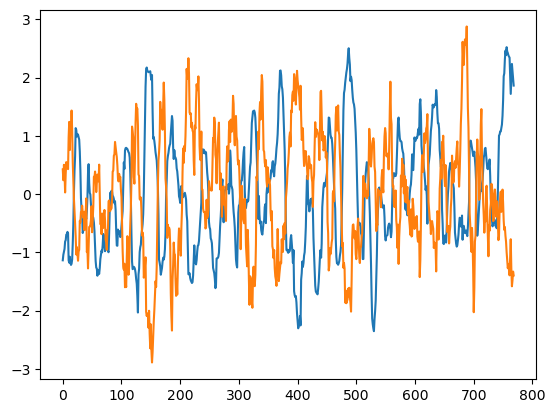

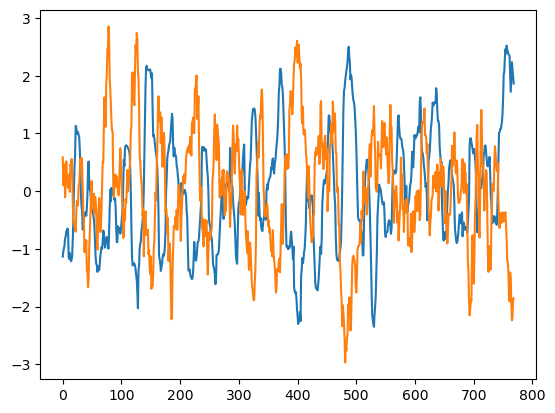

In [101]:
plt.figure()
plt.plot(pac_pos[~np.isnan(pac_pos)])
plt.plot(z500_PC2_ts[~np.isnan(pac_pos)])

plt.figure()
plt.plot(pac_pos[~np.isnan(pac_pos)])
plt.plot(I_PSA_pac_pos_ts[~np.isnan(pac_pos)])

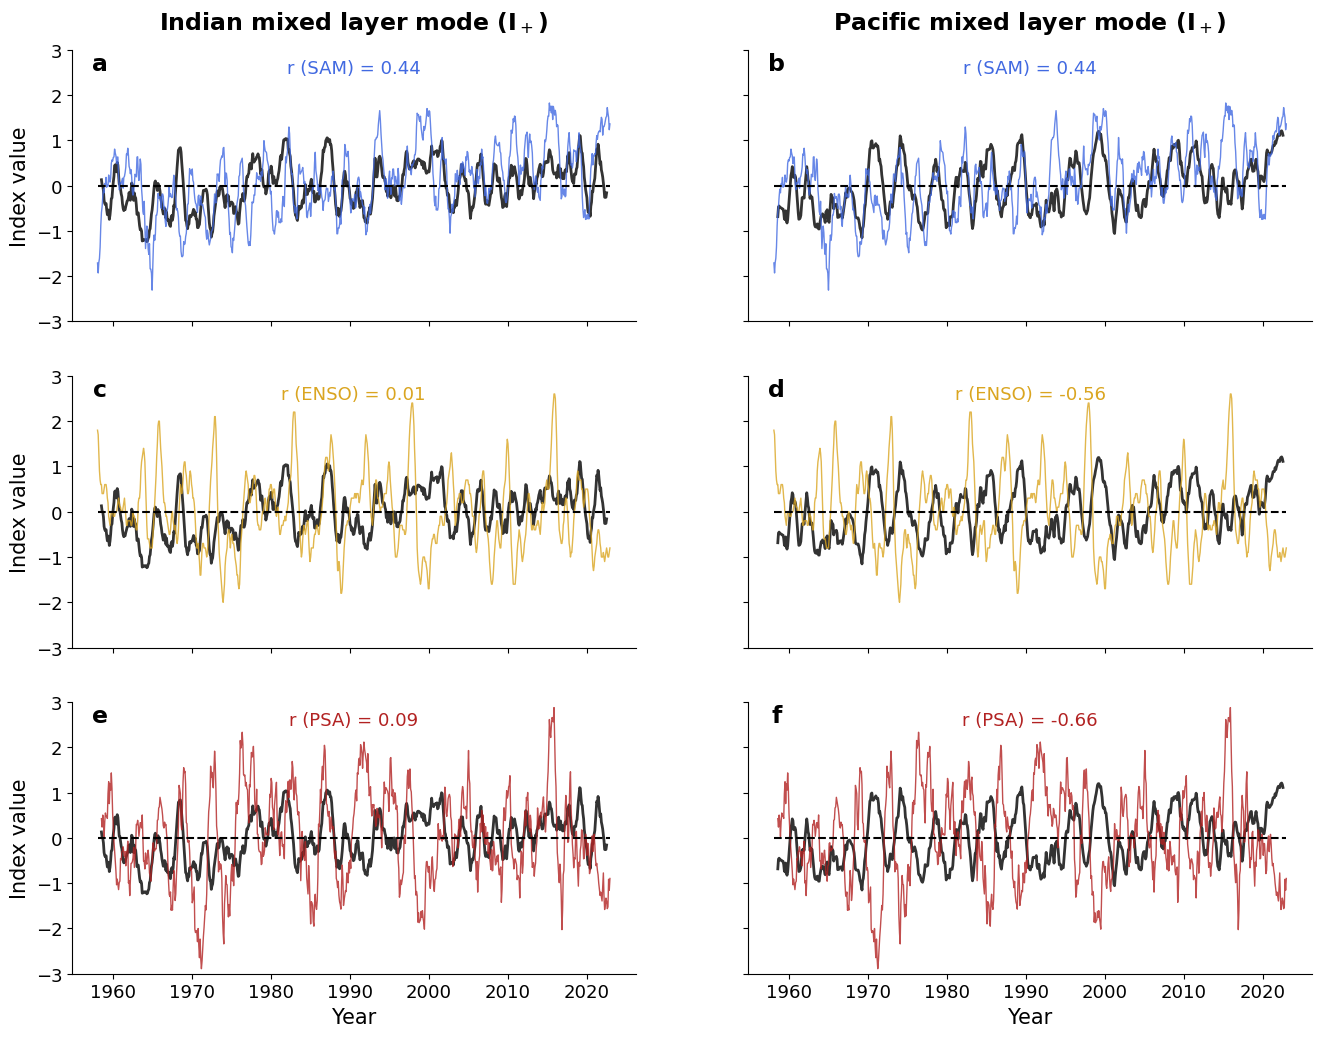

In [57]:

cols = ['k', 'royalblue', 'goldenrod', 'firebrick']
fstic = 13
fslab = 15
wid = 1.0

fig = plt.figure(figsize=(16,12), facecolor='w')
gs = GridSpec(3,2)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[2,0])
ax6 = plt.subplot(gs[2,1])

ax1.spines[['top','right']].set_visible(False)
ax2.spines[['top','right']].set_visible(False)
ax3.spines[['top','right']].set_visible(False)
ax4.spines[['top','right']].set_visible(False)
ax5.spines[['top','right']].set_visible(False)
ax6.spines[['top','right']].set_visible(False)

ax1.tick_params(labelsize=fstic, labelbottom=False)
ax2.tick_params(labelsize=fstic, labelbottom=False, labelleft=False)
ax3.tick_params(labelsize=fstic, labelbottom=False)
ax4.tick_params(labelsize=fstic, labelbottom=False, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)

time = I_ind_pos.rolling(time=12, center=True).mean().coords['time']

labs = ['I$^{MLD}_{+}$ (Indian)', 'SAM']
ax1.plot(time, I_ind_pos.rolling(time=12, center=True).mean(), color=cols[0], linewidth=wid*2, alpha=0.8, label=labs[0])
ax1.plot(time, sam_ts, color=cols[1], linewidth=wid, alpha=0.8, label=labs[1])

labs = ['I$^{MLD}_{+}$ (Pacific)', 'SAM']
ax2.plot(time, I_pac_pos.rolling(time=12, center=True).mean(), color=cols[0], linewidth=wid*2, alpha=0.8, label=labs[0])
ax2.plot(time, sam_ts, color=cols[1], linewidth=wid, alpha=0.8, label=labs[1])

labs = ['I$^{MLD}_{\pm}$ (Indian)', 'ENSO']
ax3.plot(time, I_ind_pos.rolling(time=12, center=True).mean(), color=cols[0], linewidth=wid*2, alpha=0.8, label=labs[0])
ax3.plot(time, enso_ts, color=cols[2], linewidth=wid, alpha=0.8, label=labs[1])

labs = ['I$^{MLD}_{\pm}$ (Pacific)', 'ENSO']
ax4.plot(time, I_pac_pos.rolling(time=12, center=True).mean(), color=cols[0], linewidth=wid*2, alpha=0.8, label=labs[0])
ax4.plot(time, enso_ts, color=cols[2], linewidth=wid, alpha=0.8, label=labs[1])

labs = ['I$^{MLD}_{\pm}$ (Indian)', 'PDO']
ax5.plot(time, I_ind_pos.rolling(time=12, center=True).mean(), color=cols[0], linewidth=wid*2, alpha=0.8, label=labs[0])
ax5.plot(time, z500_PC2_ts_norm, color=cols[3], linewidth=wid, alpha=0.8, label=labs[1])

labs = ['I$^{MLD}_{\pm}$ (Pacific)', 'PDO']
ax6.plot(time, I_pac_pos.rolling(time=12, center=True).mean(), color=cols[0], linewidth=wid*2, alpha=0.8, label=labs[0])
ax6.plot(time, z500_PC2_ts_norm, color=cols[3], linewidth=wid, alpha=0.8, label=labs[1])

ax5.set_xlabel('Year', fontsize=fslab)
ax6.set_xlabel('Year', fontsize=fslab)
ax1.set_ylabel('Index value', fontsize=fslab)
ax3.set_ylabel('Index value', fontsize=fslab)
ax5.set_ylabel('Index value', fontsize=fslab)

ind = I_ind_pos.rolling(time=12, center=True).mean()
pac = I_pac_pos.rolling(time=12, center=True).mean()

# add Pearson correlations
import scipy.stats as sci
enso_pac_r = sci.pearsonr(pac[~np.isnan(pac)],enso_ts[~np.isnan(pac)])
sam_pac_r = sci.pearsonr(pac[~np.isnan(pac)],sam_ts[~np.isnan(pac)])
pdo_pac_r = sci.pearsonr(pac[~np.isnan(pac)],z500_PC2_ts[~np.isnan(pac)])
enso_ind_r = sci.pearsonr(ind[~np.isnan(ind)],enso_ts[~np.isnan(ind)])
sam_ind_r = sci.pearsonr(ind[~np.isnan(ind)],sam_ts[~np.isnan(ind)])
pdo_ind_r = sci.pearsonr(ind[~np.isnan(ind)],z500_PC2_ts[~np.isnan(ind)])

xx = 0.5; yy = 0.9
plt.text(xx,yy, 'r (SAM) = %.2f'%(sam_ind_pos_r[0]), color=cols[1], fontsize=fstic, va='bottom', ha='center', transform=ax1.transAxes)
plt.text(xx,yy, 'r (SAM) = %.2f'%(sam_pac_pos_r[0]), color=cols[1], fontsize=fstic, va='bottom', ha='center', transform=ax2.transAxes)
plt.text(xx,yy, 'r (ENSO) = %.2f'%(enso_ind_pos_r[0]), color=cols[2], fontsize=fstic, va='bottom', ha='center', transform=ax3.transAxes)
plt.text(xx,yy, 'r (ENSO) = %.2f'%(enso_pac_pos_r[0]), color=cols[2], fontsize=fstic, va='bottom', ha='center', transform=ax4.transAxes)
plt.text(xx,yy, 'r (PSA1) = %.2f'%(z500_PC2_ind_pos_r[0]), color=cols[3], fontsize=fstic, va='bottom', ha='center', transform=ax5.transAxes)
plt.text(xx,yy, 'r (PSA3) = %.2f'%(z500_PC2_pac_pos_r[0]), color=cols[3], fontsize=fstic, va='bottom', ha='center', transform=ax6.transAxes)

y1 = -3; y2 = 3
ax1.set_ylim(y1,y2)
ax2.set_ylim(y1,y2)
ax3.set_ylim(y1,y2)
ax4.set_ylim(y1,y2)
ax5.set_ylim(y1,y2)
ax6.set_ylim(y1,y2)

xx = 0.05; yy = 0.95
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)

ax1.plot(time, np.zeros(len(time)), 'k--')
ax2.plot(time, np.zeros(len(time)), 'k--')
ax3.plot(time, np.zeros(len(time)), 'k--')
ax4.plot(time, np.zeros(len(time)), 'k--')
ax5.plot(time, np.zeros(len(time)), 'k--')
ax6.plot(time, np.zeros(len(time)), 'k--')

plt.text(0.5,1.1, 'Indian mixed layer mode (I$_+$)', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(0.5,1.1, 'Pacific mixed layer mode (I$_+$)', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)

fig.savefig('fig-mld_eof_climatemodes.png', dpi=300, bbox_inches='tight')
fig.savefig('fig-mld_eof_climatemodes.pdf', dpi=300, bbox_inches='tight')
fig.savefig('fig-mld_eof_climatemodes_trans.png', dpi=300, bbox_inches='tight', transparent=True)



## save the indexes of MLDa (I+)

In [63]:
I_pac_pos.name = "Iplus_Pac"
I_ind_pos.name = "Iplus_Ind"

I_pac_pos.to_netcdf("/home/pbuchanan/analysis_samw/MLDa_index_Iplus_Pacific.nc")
I_ind_pos.to_netcdf("/home/pbuchanan/analysis_samw/MLDa_index_Iplus_Indian.nc")


## make Supplementary Figure 2

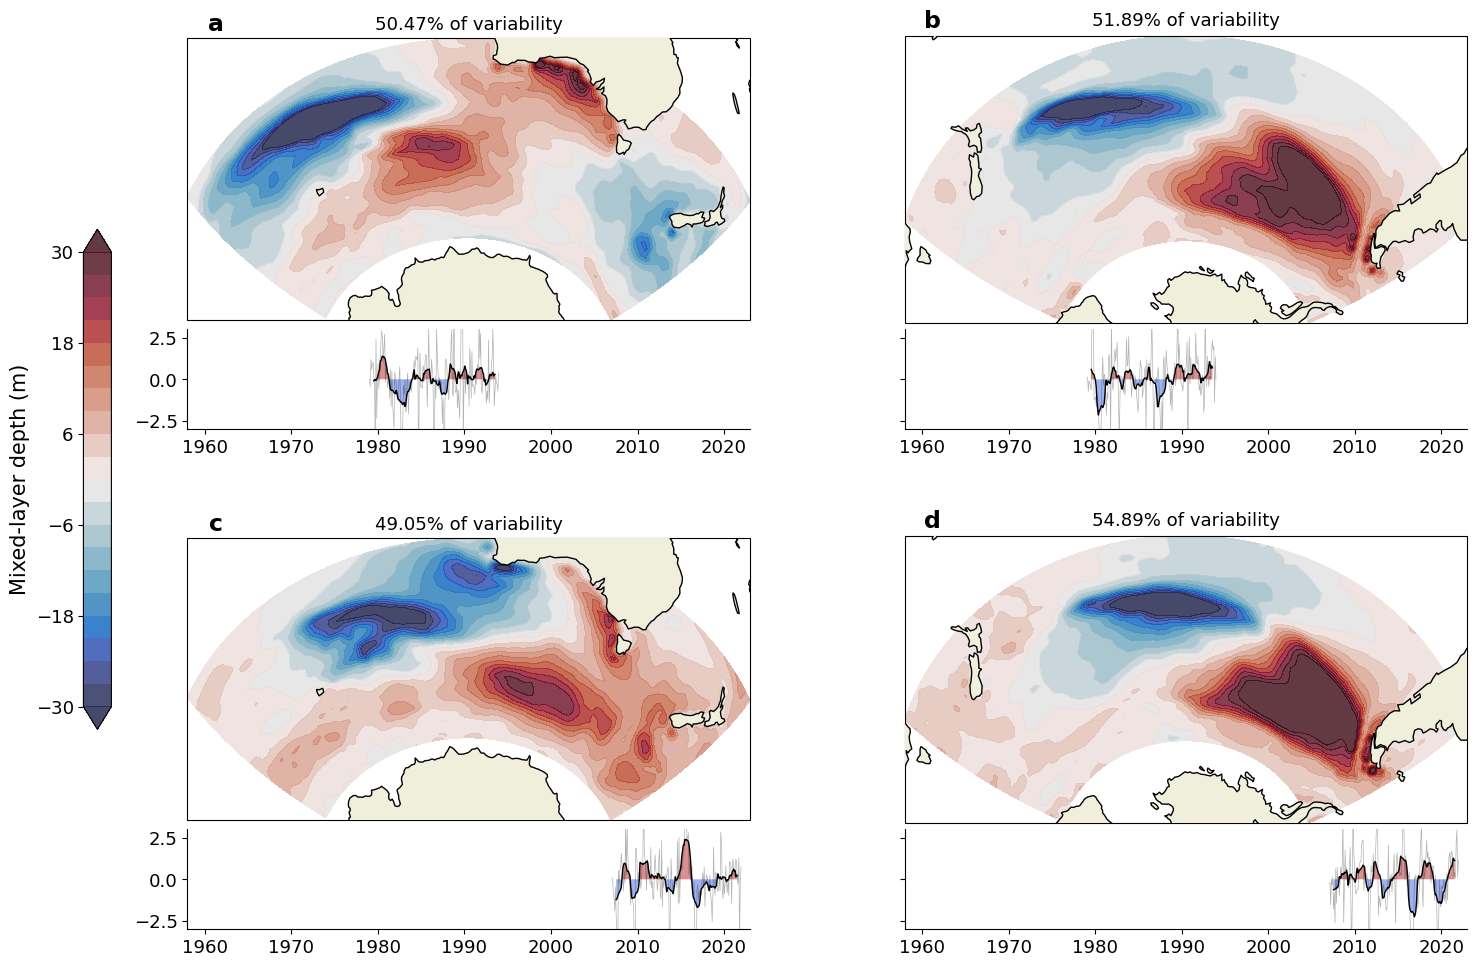

In [32]:

sind_proj = ccrs.Orthographic(central_latitude=-55, central_longitude=110)
spac_proj = ccrs.Orthographic(central_latitude=-60, central_longitude=225)

paclons = spac_mld_anom.coords['x']
paclats = spac_mld_anom.coords['y']
indlons = sind_mld_anom.coords['x']
indlats = sind_mld_anom.coords['y']


levs = np.arange(-30,31,3)
colmap = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
wid = 1.0

fig = plt.figure(figsize=(16,10), facecolor='w')
gs = GridSpec(10,2)

ax1 = plt.subplot(gs[0:3,0], projection=sind_proj)
ax2 = plt.subplot(gs[0:3,1], projection=spac_proj)
ax3 = plt.subplot(gs[5:8,0], projection=sind_proj)
ax4 = plt.subplot(gs[5:8,1], projection=spac_proj)

ax1.add_feature(cfeature.LAND, zorder=3)
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3)
ax2.add_feature(cfeature.COASTLINE, zorder=3)
ax3.add_feature(cfeature.LAND, zorder=3)
ax3.add_feature(cfeature.COASTLINE, zorder=3)
ax4.add_feature(cfeature.LAND, zorder=3)
ax4.add_feature(cfeature.COASTLINE, zorder=3)

sind_Sch_sym_3eofs = (sind_Sch_sym_eofs.sel(mode=0)+sind_Sch_sym_eofs.sel(mode=1)+sind_Sch_sym_eofs.sel(mode=2))
spac_Sch_sym_3eofs = (-spac_Sch_sym_eofs.sel(mode=0)+spac_Sch_sym_eofs.sel(mode=1)-spac_Sch_sym_eofs.sel(mode=2))
sind_Sch_asy_3eofs = (-sind_Sch_asy_eofs.sel(mode=0)+sind_Sch_asy_eofs.sel(mode=1)+sind_Sch_asy_eofs.sel(mode=2))
spac_Sch_asy_3eofs = (spac_Sch_asy_eofs.sel(mode=0)-spac_Sch_asy_eofs.sel(mode=1)-spac_Sch_asy_eofs.sel(mode=2))

sind_Sch_sym_3pcs = (-sind_Sch_sym_pcs.sel(mode=0)+sind_Sch_sym_pcs.sel(mode=1)+sind_Sch_sym_pcs.sel(mode=2))
spac_Sch_sym_3pcs = (-spac_Sch_sym_pcs.sel(mode=0)+spac_Sch_sym_pcs.sel(mode=1)-spac_Sch_sym_pcs.sel(mode=2))
sind_Sch_asy_3pcs = (-sind_Sch_asy_pcs.sel(mode=0)+sind_Sch_asy_pcs.sel(mode=1)+sind_Sch_asy_pcs.sel(mode=2))
spac_Sch_asy_3pcs = (spac_Sch_asy_pcs.sel(mode=0)-spac_Sch_asy_pcs.sel(mode=1)-spac_Sch_asy_pcs.sel(mode=2))

p1 = ax1.contourf(indlons,indlats, sind_Sch_sym_3eofs, transform=ccrs.PlateCarree(), levels=levs, cmap=colmap, vmin=np.min(levs), vmax=np.max(levs), extend='both')
p2 = ax2.contourf(paclons,paclats, spac_Sch_sym_3eofs, transform=ccrs.PlateCarree(), levels=levs, cmap=colmap, vmin=np.min(levs), vmax=np.max(levs), extend='both')
p3 = ax3.contourf(indlons,indlats, sind_Sch_asy_3eofs, transform=ccrs.PlateCarree(), levels=levs, cmap=colmap, vmin=np.min(levs), vmax=np.max(levs), extend='both')
p4 = ax4.contourf(paclons,paclats, spac_Sch_asy_3eofs, transform=ccrs.PlateCarree(), levels=levs, cmap=colmap, vmin=np.min(levs), vmax=np.max(levs), extend='both')

ax5 = plt.subplot(gs[3,0])
ax6 = plt.subplot(gs[3,1])
ax7 = plt.subplot(gs[8,0])
ax8 = plt.subplot(gs[8,1])

ax5.tick_params(labelsize=fstic)
ax5.spines[['top','right']].set_visible(False)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax6.spines[['top','right']].set_visible(False)
ax7.tick_params(labelsize=fstic)
ax7.spines[['top','right']].set_visible(False)
ax8.tick_params(labelsize=fstic, labelleft=False)
ax8.spines[['top','right']].set_visible(False)


# plot the PCs time-series
sind_Sch_sym_pc_smooth = sind_Sch_sym_3pcs.rolling(time=12, center=True).mean()
spac_Sch_sym_pc_smooth = spac_Sch_sym_3pcs.rolling(time=12, center=True).mean()
sind_Sch_asy_pc_smooth = sind_Sch_asy_3pcs.rolling(time=12, center=True).mean()
spac_Sch_asy_pc_smooth = spac_Sch_asy_3pcs.rolling(time=12, center=True).mean()

ax5.plot(sind_Sch_sym_pcs['time'], sind_Sch_sym_3pcs, linewidth=0.5, alpha=0.3, color='k')
ax5.plot(sind_Sch_sym_pcs['time'], sind_Sch_sym_pc_smooth, linewidth=1, color='k')
pcs_pos = np.ma.masked_where(sind_Sch_sym_pc_smooth<0, sind_Sch_sym_pc_smooth)
pcs_neg = np.ma.masked_where(sind_Sch_sym_pc_smooth>0, sind_Sch_sym_pc_smooth)
ax5.fill_between(sind_Sch_sym_pcs['time'], pcs_pos, alpha=0.5, facecolor='firebrick')
ax5.fill_between(sind_Sch_sym_pcs['time'], pcs_neg, alpha=0.5, facecolor='royalblue')

ax6.plot(spac_Sch_sym_pcs['time'], spac_Sch_sym_3pcs, linewidth=0.5, alpha=0.3, color='k')
ax6.plot(spac_Sch_sym_pcs['time'], spac_Sch_sym_pc_smooth, linewidth=1, color='k')
pcs_pos = np.ma.masked_where(spac_Sch_sym_pc_smooth<0, spac_Sch_sym_pc_smooth)
pcs_neg = np.ma.masked_where(spac_Sch_sym_pc_smooth>0, spac_Sch_sym_pc_smooth)
ax6.fill_between(spac_Sch_sym_pcs['time'], pcs_pos, alpha=0.5, facecolor='firebrick')
ax6.fill_between(spac_Sch_sym_pcs['time'], pcs_neg, alpha=0.5, facecolor='royalblue')

ax7.plot(sind_Sch_asy_pcs['time'], sind_Sch_asy_3pcs, linewidth=0.5, alpha=0.3, color='k')
ax7.plot(sind_Sch_asy_pcs['time'], sind_Sch_asy_pc_smooth, linewidth=1, color='k')
pcs_pos = np.ma.masked_where(sind_Sch_asy_pc_smooth<0, sind_Sch_asy_pc_smooth)
pcs_neg = np.ma.masked_where(sind_Sch_asy_pc_smooth>0, sind_Sch_asy_pc_smooth)
ax7.fill_between(sind_Sch_asy_pcs['time'], pcs_pos, alpha=0.5, facecolor='firebrick')
ax7.fill_between(sind_Sch_asy_pcs['time'], pcs_neg, alpha=0.5, facecolor='royalblue')

ax8.plot(spac_Sch_asy_pcs['time'], spac_Sch_asy_3pcs, linewidth=0.5, alpha=0.3, color='k')
ax8.plot(spac_Sch_asy_pcs['time'], spac_Sch_asy_pc_smooth, linewidth=1, color='k')
pcs_pos = np.ma.masked_where(spac_Sch_asy_pc_smooth<0, spac_Sch_asy_pc_smooth)
pcs_neg = np.ma.masked_where(spac_Sch_asy_pc_smooth>0, spac_Sch_asy_pc_smooth)
ax8.fill_between(spac_Sch_asy_pcs['time'], pcs_pos, alpha=0.5, facecolor='firebrick')
ax8.fill_between(spac_Sch_asy_pcs['time'], pcs_neg, alpha=0.5, facecolor='royalblue')

ax1.text(0.5,1.05,'%.2f%% of variability'%((sind_Sch_sym_varfrac.sel(mode=0)+sind_Sch_sym_varfrac.sel(mode=1)+sind_Sch_sym_varfrac.sel(mode=2))*100), transform=ax1.transAxes, va='center', ha='center', fontsize=fstic)
ax2.text(0.5,1.05,'%.2f%% of variability'%((spac_Sch_sym_varfrac.sel(mode=0)+spac_Sch_sym_varfrac.sel(mode=1)+spac_Sch_sym_varfrac.sel(mode=2))*100), transform=ax2.transAxes, va='center', ha='center', fontsize=fstic)
ax3.text(0.5,1.05,'%.2f%% of variability'%((sind_Sch_asy_varfrac.sel(mode=0)+sind_Sch_asy_varfrac.sel(mode=1)+sind_Sch_asy_varfrac.sel(mode=2))*100), transform=ax3.transAxes, va='center', ha='center', fontsize=fstic)
ax4.text(0.5,1.05,'%.2f%% of variability'%((spac_Sch_asy_varfrac.sel(mode=0)+spac_Sch_asy_varfrac.sel(mode=1)+spac_Sch_asy_varfrac.sel(mode=2))*100), transform=ax4.transAxes, va='center', ha='center', fontsize=fstic)

plt.subplots_adjust(left=0.15, top=0.95, right=0.95, hspace=0.0, bottom=-0.05, wspace=0.275)

ax5.set_xlim(start_date,end_date); ax5.set_ylim(-3,3)
ax6.set_xlim(start_date,end_date); ax6.set_ylim(-3,3)
ax7.set_xlim(start_date,end_date); ax7.set_ylim(-3,3)
ax8.set_xlim(start_date,end_date); ax8.set_ylim(-3,3)

xx = 0.05; yy = 1.05
ax1.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
ax2.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
ax3.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
ax4.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)

cbax = fig.add_axes([0.085,0.25,0.0175,0.5])
cbar1 = plt.colorbar(p1, cax=cbax, orientation='vertical', ticks=levs[::4])
cbar1.ax.tick_params(labelsize=fstic, right=False, labelright=False, left=True, labelleft=True)
cbar1.ax.set_ylabel('Mixed-layer depth (m)', fontsize=fslab)
cbar1.ax.yaxis.set_label_position('left')


#%% save EOFs on Schroeter timescales of symmetrical and asymmetrical SAM

fig.savefig('fig-mld_eof_SchroeterSAM.png', dpi=300, bbox_inches='tight')
fig.savefig('fig-mld_eof_SchroeterSAM_trans.png', dpi=300, bbox_inches='tight', transparent=True)



## Make Supplementary Figure 3

### download the data

In [34]:
wrkdir

'/expanse/lustre/projects/ciw112/pbuchanan/JRA55'

In [33]:
os.getcwd()

import urllib.request

months = np.array(['01','02','03','04','05','06','07','08','09','10','11','12'])

for year in np.arange(1993,2023,1):
    yr = str(year)
    for mn in months:
        url = "https://dapds00.nci.org.au/thredds/fileServer/gb6/BRAN/BRAN2020/month/ocean_mld_mth_"+yr+"_"+mn+".nc"
        urllib.request.urlretrieve(url, wrkdir + "../BRAN2020/mld_mth_"+yr+"_"+mn+".nc")


URLError: <urlopen error [Errno 113] No route to host>

In [ ]:

mod = xr.open_mfdataset('BRAN2020/mld_mth_*.nc', combine='nested', concat_dim=['Time'])

# view result
levs = np.arange(0,301,10)
proj = ccrs.PlateCarree()
plt.figure()
ax1 = plt.subplot(projection=proj)
ax1.contourf(mod.coords['xt_ocean'], mod.coords['yt_ocean'], mod['mld'].isel(Time=8), transform=ccrs.PlateCarree(), levels=levs)
ax1.add_feature(cfeature.COASTLINE)

# retrieve information
lon = mod.coords['xt_ocean']
lat = mod.coords['yt_ocean']
time = mod.coords['Time']